### Melanoma (Jerby-Anon)

In [ ]:
library(Seurat)
library(data.table)
library(readxl)
counts_melanoma = fread('/mnt/grid/janowitz/rdata_norepl/single_cell/melanoma/SCP109/expression/tumors_tpm.txt')
names = counts_melanoma$GENE
counts_melanoma = counts_melanoma[,-1]
row.names(counts_melanoma) = names

metadata = fread('/mnt/grid/janowitz/rdata_norepl/single_cell/melanoma/SCP109/metadata/GSE115978_cell.annotations.csv.gz')
names = metadata$cells
metadata = metadata[,-1]
row.names(metadata) = names

clinical = read_excel('/mnt/grid/janowitz/rdata_norepl/single_cell/melanoma/SCP109/metadata/jerbyanon_clinical.xlsx')
names(clinical)[1]="samples"
clinical$samples[clinical$samples=="Mel129PA"] = "Mel129pa"
clinical$samples[clinical$samples=="Mel129PB"] = "Mel129pb"
clinical$response = ifelse(clinical$response=="untreated", "naive","treated")
m<-match(metadata$samples, clinical$samples)
metadata$response = clinical$response[m]

melanoma <- CreateSeuratObject(counts = data.matrix(counts_melanoma), project = "melanoma_scp109", min.cells = 10, min.features = 200,
                              meta.data = metadata)

melanoma[["percent.mt"]] <- PercentageFeatureSet(melanoma, pattern = "^mt-")
VlnPlot(melanoma, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
melanoma <- subset(melanoma, subset = nFeature_RNA > 750 & nFeature_RNA < 10000 & percent.mt < 15)

melanoma <- FindVariableFeatures(melanoma, selection.method = "vst", nfeatures = 2000)

all.genes <- rownames(melanoma)
melanoma <- ScaleData(melanoma, features = all.genes)

melanoma <- RunPCA(object = melanoma, npcs=30)
melanoma <- FindNeighbors(object = melanoma, dims = 1:20)
melanoma <- FindClusters(object = melanoma, resolution = 0.5, algorithm = 1)
melanoma <- RunTSNE(object = melanoma, dims.use = 1:10, check_duplicates = FALSE)
DimPlot(object = melanoma, reduction = "tsne")
melanoma <- RunUMAP(melanoma, reduction = "pca", dims = 1:20)
DimPlot(melanoma, reduction = "umap")


13:41:51 UMAP embedding parameters a = 0.9922 b = 1.112

13:41:51 Read 7125 rows and found 20 numeric columns

13:41:51 Using Annoy for neighbor search, n_neighbors = 30

13:41:51 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:41:52 Writing NN index file to temp file /tmp/3843246.1.comp.q/Rtmp6dXRr0/file1565ea4a6277d8

13:41:52 Searching Annoy index using 1 thread, search_k = 3000

13:41:54 Annoy recall = 100%

13:41:55 Commencing smooth kNN distance calibration using 1 thread

13:41:56 Initializing from normalized Laplacian + noise

13:41:56 Commencing optimization for 500 epochs, with 292858 positive edges

13:42:05 Optimization finished



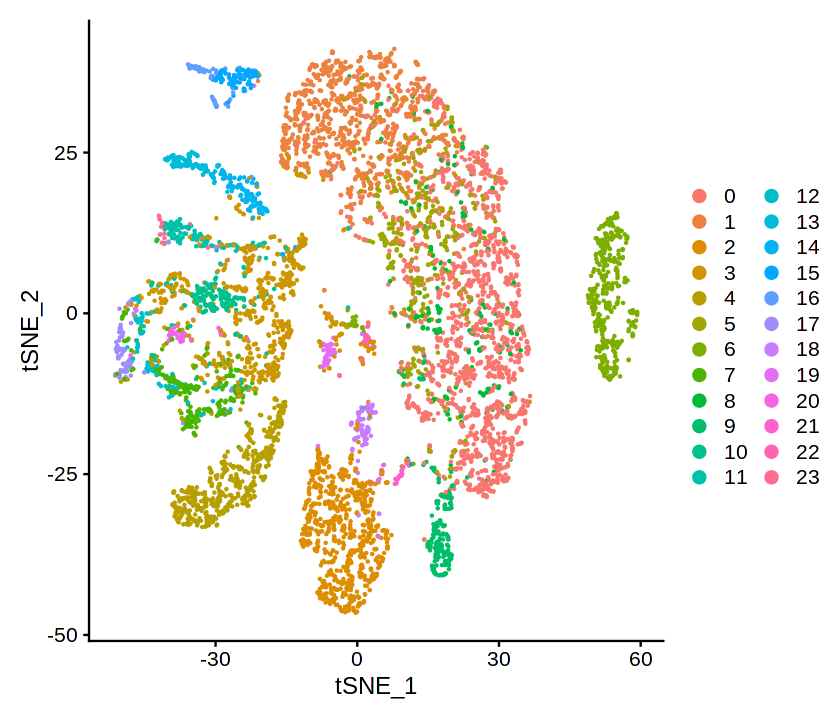

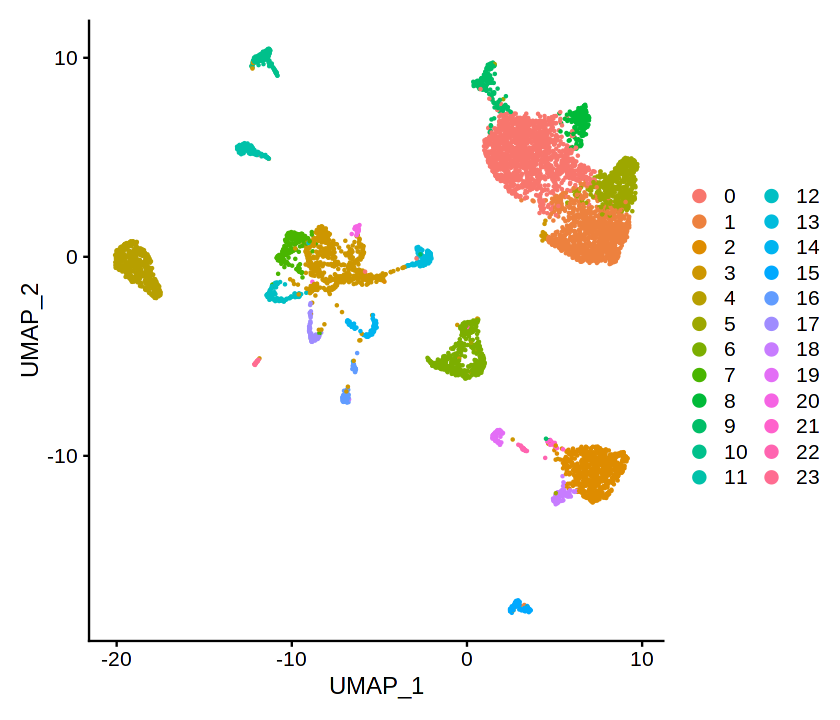

In [37]:
melanoma <- RunTSNE(object = melanoma, dims.use = 1:10, check_duplicates = FALSE)
DimPlot(object = melanoma, reduction = "tsne")
melanoma <- RunUMAP(melanoma, reduction = "pca", dims = 1:20)
DimPlot(melanoma, reduction = "umap")

using threshold of 0.6



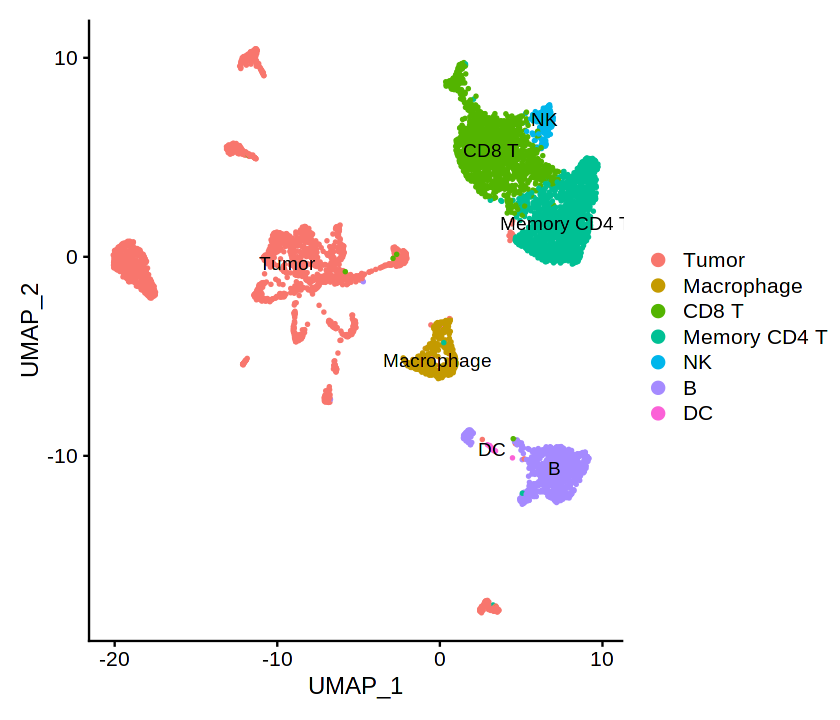

In [43]:
options(repr.plot.width=7, repr.plot.height=6)

library(clustifyr)
library(clustifyrdata)

res <- clustify(
  input = melanoma,       # a Seurat object
  ref_mat = clustifyrdata::pbmc_avg,    # matrix of RNA-seq expression data for each cell type
  cluster_col = "RNA_snn_res.0.5", # name of column in meta.data containing cell clusters
  obj_out = TRUE,      # output Seurat object with cell type inserted as "type" column
  query_genes = clustifyrdata::pbmc_vargenes[1:500]
)

res@meta.data$type[res@meta.data$type=='unassigned']='Tumor'
#res@meta.data$type[res@meta.data$seurat_clusters==14 | res@meta.data$seurat_clusters==14]='Endothelial'
#res@meta.data$type[res@meta.data$seurat_clusters==15 | res@meta.data$seurat_clusters==15]='CAF'

res@meta.data$type[res@meta.data$type=='CD14+ Mono']='Macrophage'

Idents(object = res) <- res@meta.data$type

DimPlot(res, reduction = "umap", label = TRUE, pt.size = 0.5)

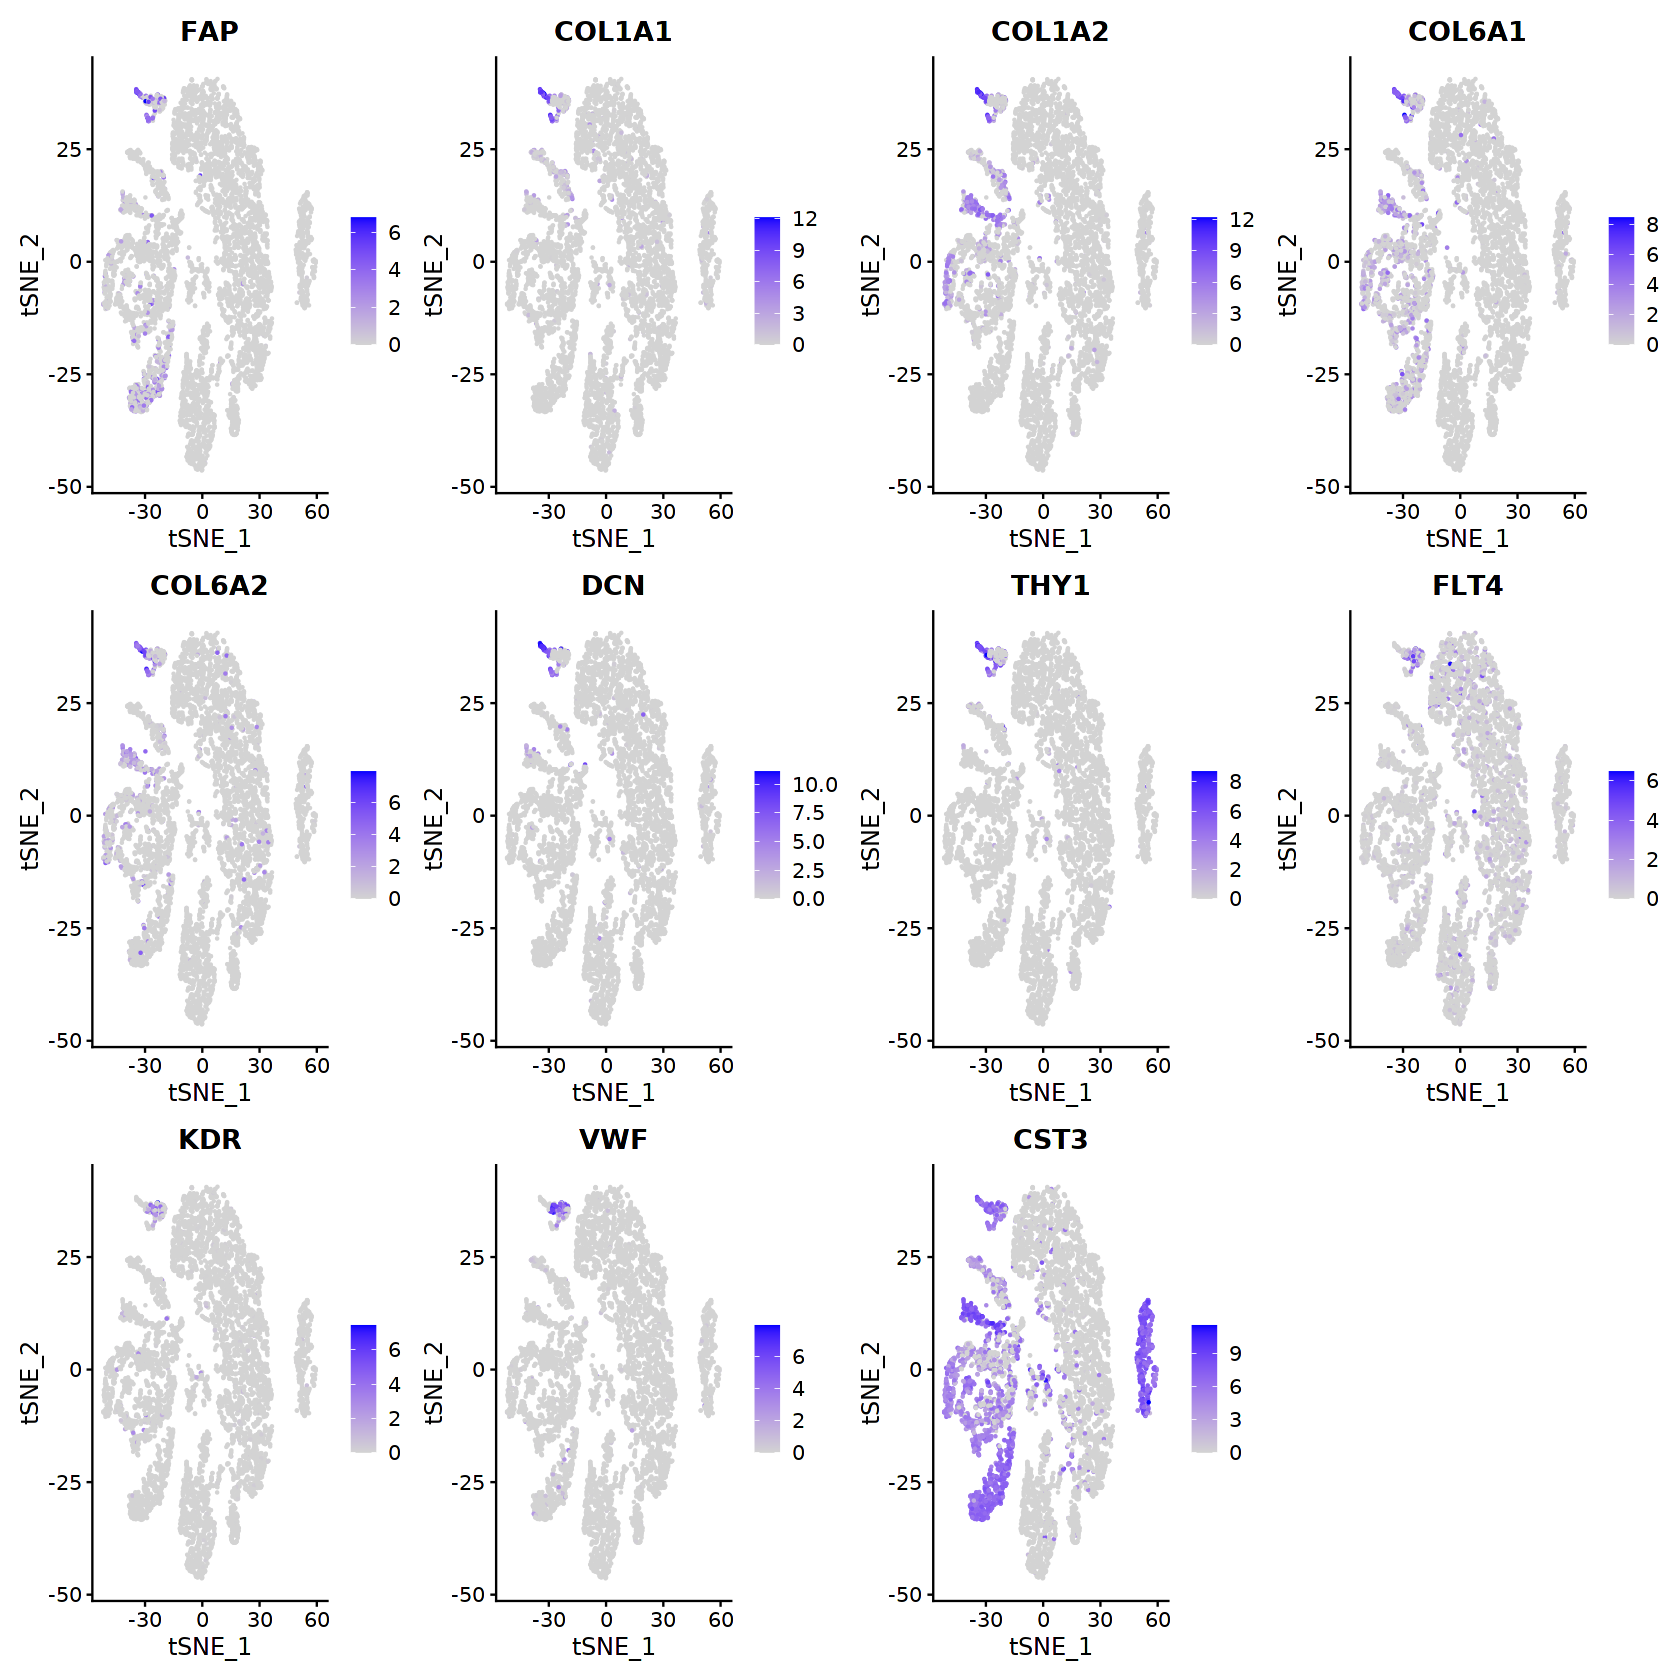

In [59]:
options(repr.plot.width=14, repr.plot.height=14)
FeaturePlot(melanoma, features = c("FAP", "COL1A1", "COL1A2", "COL6A1", 
    "COL6A2","DCN","THY1","FLT4","KDR","VWF","CST3"))

In [31]:
#InferCNV
library(infercnv)

counts_matrix = as.matrix(res@assays$RNA@counts[,colnames(res)])
annotations = data.frame(id = row.names(res@meta.data), type = res@meta.data$type, sample = res@meta.data$samples)
annotations$type[annotations$type=="Tumor"]=paste('malignant_',annotations$sample[annotations$type=="Tumor"],sep='')
annotations = annotations[,-3]

library(dplyr)
annotations = annotations %>% 
  group_by(type) %>% 
  filter(n_distinct(id) >= 2)

write.table(annotations, file = "ann.tsv", row.names=FALSE, sep="\t",col.names = F)

infercnv_obj = CreateInfercnvObject(counts_matrix,
                                    annotations_file='ann.tsv',
                                    delim="\t",
                                    gene_order_file='~/gencode_v19_gene_pos.txt',
                                    ref_group_names=c("CD8 T", "Memory CD4 T", "Naive CD4 T", "B","Macrophage")) 


INFO [2021-06-22 22:38:43] Parsing gene order file: ~/gencode_v19_gene_pos.txt
INFO [2021-06-22 22:38:44] Parsing cell annotations file: ann.tsv
INFO [2021-06-22 22:38:44] ::order_reduce:Start.
INFO [2021-06-22 22:38:44] .order_reduce(): expr and order match.
INFO [2021-06-22 22:38:45] ::process_data:order_reduce:Reduction from positional data, new dimensions (r,c) = 21590,7125 Total=73520871.8954969 Min=0 Max=15.9229677186345.
INFO [2021-06-22 22:38:45] num genes removed taking into account provided gene ordering list: 2368 = 10.9680407596109% removed.
INFO [2021-06-22 22:38:46] -filtering out cells < 100 or > Inf, removing 0 % of cells
INFO [2021-06-22 22:38:52] validating infercnv_obj


In [28]:
infercnv_obj

In [ ]:
infercnv_obj = infercnv::run(infercnv_obj,
                             cutoff=0.1,
                             out_dir='~/output_new',
                             ref_subtract_use_mean_bounds=TRUE,
                             cluster_by_groups=TRUE, 
                             denoise=TRUE,
                             sd_amplifier=3,  # sets midpoint for logistic
                             noise_logistic=TRUE, # turns gradient filtering on
                             HMM=TRUE,
                             HMM_type="i6",
                             HMM_report_by="subcluster",
                             analysis_mode="subcluster",
                             tumor_subcluster_partition_method="random_trees",
                             tumor_subcluster_pval=0.05,num_threads=8)

INFO [2021-06-22 22:39:44] ::process_data:Start
INFO [2021-06-22 22:39:44] Creating output path ~/output_new
INFO [2021-06-22 22:39:44] Checking for saved results.
INFO [2021-06-22 22:39:44] 

	STEP 1: incoming data

INFO [2021-06-22 22:40:20] 

	STEP 02: Removing lowly expressed genes

INFO [2021-06-22 22:40:20] ::above_min_mean_expr_cutoff:Start
INFO [2021-06-22 22:40:20] Removing 7495 genes from matrix as below mean expr threshold: 0.1
INFO [2021-06-22 22:40:21] validating infercnv_obj
INFO [2021-06-22 22:40:21] There are 11727 genes and 7124 cells remaining in the expr matrix.
INFO [2021-06-22 22:40:24] no genes removed due to min cells/gene filter
INFO [2021-06-22 22:40:54] 

	STEP 03: normalization by sequencing depth

INFO [2021-06-22 22:40:54] normalizing counts matrix by depth
INFO [2021-06-22 22:40:55] Computed total sum normalization factor as median libsize: 8903.271707
INFO [2021-06-22 22:40:55] Adding h-spike
INFO [2021-06-22 22:40:55] -hspike modeling of CD8 T
INFO [2021

unique tumor clade name: malignant_Mel78.1



INFO [2021-06-22 22:54:49] random trees, using 8 parallel threads


Lengths for original tree branches (h): 4.46871194833565,4.52079658662788,4.70612374884261,4.72351233670498,4.72738183985164,4.75756227593207,4.76349593823186,4.86851478792083,4.99349951588758,4.99832987005555,5.056217209796,5.05650222245022,5.10751334508171,5.14107998237751,5.17658323420845,5.1788168275969,5.20624332744874,5.25849615897642,5.32701762463431,5.48006500661039,5.49172999831936,5.49885984910949,5.52712886747946,5.55688459964211,5.55940542576159,5.60288129756511,5.60641908688673,5.77166449897928,5.80018473922772,5.80306417251426,5.83484837465431,5.85595769891735,5.86441310789056,5.88187452417668,5.91522807565087,5.9661397192671,5.96780550508576,5.97031456143659,5.9715137153403,5.99717789013142,6.01304840829075,6.03630040607585,6.08304794138275,6.16568101307918,6.2436010986191,6.28554258850772,6.30235956631406,6.36769843655781,6.39856317016215,6.40292530225233,6.45846753437954,6.50750905689088,6.54569734211522,6.55119738547827,6.58896018008385,6.5963460875746,6.6137226602336

INFO [2021-06-22 22:55:03] cutting at height: 26.4595
cy78_CD45_neg_1_B04_S496_comb cy78_CD45_neg_3_H06_S762_comb 
                            1                             1 
cy78_CD45_neg_1_D07_S523_comb cy78_CD45_neg_3_D01_S709_comb 
                            1                             1 
cy78_CD45_neg_2_B08_S596_comb cy78_CD45_neg_1_E02_S530_comb 
                            1                             1 
cy78_CD45_neg_3_B02_S686_comb cy78_CD45_neg_3_D04_S712_comb 
                            1                             1 
cy78_CD45_neg_3_E02_S722_comb cy78_CD45_neg_3_D10_S718_comb 
                            1                             1 
cy78_CD45_neg_1_G05_S557_comb cy78_CD45_neg_3_G11_S755_comb 
                            1                             1 
cy78_CD45_neg_1_H01_S565_comb cy78_CD45_neg_1_C02_S506_comb 
                            1                             1 
cy78_CD45_neg_1_A05_S485_comb cy78_CD45_neg_1_E03_S531_comb 
                            1  

unique grps: 1,,2,

grp: 1  contains idx: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,115,116,117,118,119,120,121

subset_clade_name: malignant_Mel78.1.1

unique tumor clade name: malignant_Mel78.1.1



INFO [2021-06-22 22:55:04] random trees, using 8 parallel threads


Lengths for original tree branches (h): 4.46871194833565,4.52079658662788,4.70612374884261,4.72351233670498,4.72738183985164,4.75756227593207,4.76349593823186,4.86851478792083,4.99349951588758,4.99832987005555,5.056217209796,5.05650222245022,5.10751334508171,5.14107998237751,5.17658323420845,5.1788168275969,5.20624332744874,5.25849615897642,5.32701762463431,5.48006500661039,5.49172999831936,5.49885984910949,5.52712886747946,5.55688459964211,5.55940542576159,5.60288129756511,5.60641908688673,5.77166449897928,5.80018473922772,5.80306417251426,5.83484837465431,5.85595769891735,5.86441310789056,5.88187452417668,5.91522807565087,5.9661397192671,5.96780550508576,5.97031456143659,5.9715137153403,5.99717789013142,6.01304840829075,6.03630040607585,6.08304794138275,6.16568101307918,6.2436010986191,6.28554258850772,6.30235956631406,6.36769843655781,6.39856317016215,6.40292530225233,6.45846753437954,6.50750905689088,6.54569734211522,6.55119738547827,6.58896018008385,6.5963460875746,6.6137226602336

INFO [2021-06-22 22:55:17] cutting at height: 20.354
cy78_CD45_neg_1_B04_S496_comb cy78_CD45_neg_3_H06_S762_comb 
                            1                             1 
cy78_CD45_neg_1_D07_S523_comb cy78_CD45_neg_3_D01_S709_comb 
                            1                             1 
cy78_CD45_neg_2_B08_S596_comb cy78_CD45_neg_1_E02_S530_comb 
                            1                             1 
cy78_CD45_neg_3_B02_S686_comb cy78_CD45_neg_3_D04_S712_comb 
                            1                             1 
cy78_CD45_neg_3_E02_S722_comb cy78_CD45_neg_3_D10_S718_comb 
                            1                             1 
cy78_CD45_neg_1_G05_S557_comb cy78_CD45_neg_3_G11_S755_comb 
                            1                             1 
cy78_CD45_neg_1_H01_S565_comb cy78_CD45_neg_1_C02_S506_comb 
                            1                             1 
cy78_CD45_neg_1_A05_S485_comb cy78_CD45_neg_1_E03_S531_comb 
                            1   

unique grps: 1,,2,

grp: 1  contains idx: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,116,118,119,120

subset_clade_name: malignant_Mel78.1.1.1

unique tumor clade name: malignant_Mel78.1.1.1



INFO [2021-06-22 22:55:17] random trees, using 8 parallel threads


Lengths for original tree branches (h): 4.46871194833565,4.52079658662788,4.70612374884261,4.72351233670498,4.72738183985164,4.75756227593207,4.76349593823186,4.86851478792083,4.99349951588758,4.99832987005555,5.056217209796,5.05650222245022,5.10751334508171,5.14107998237751,5.17658323420845,5.1788168275969,5.20624332744874,5.25849615897642,5.32701762463431,5.48006500661039,5.49172999831936,5.49885984910949,5.52712886747946,5.55688459964211,5.55940542576159,5.60288129756511,5.60641908688673,5.77166449897928,5.80018473922772,5.80306417251426,5.83484837465431,5.85595769891735,5.86441310789056,5.88187452417668,5.91522807565087,5.9661397192671,5.96780550508576,5.97031456143659,5.9715137153403,5.99717789013142,6.01304840829075,6.03630040607585,6.08304794138275,6.16568101307918,6.2436010986191,6.28554258850772,6.30235956631406,6.36769843655781,6.39856317016215,6.40292530225233,6.45846753437954,6.50750905689088,6.54569734211522,6.55119738547827,6.58896018008385,6.5963460875746,6.6137226602336

INFO [2021-06-22 22:55:31] cutting at height: 17.4818
cy78_CD45_neg_1_B04_S496_comb cy78_CD45_neg_3_H06_S762_comb 
                            1                             1 
cy78_CD45_neg_1_D07_S523_comb cy78_CD45_neg_3_D01_S709_comb 
                            1                             1 
cy78_CD45_neg_2_B08_S596_comb cy78_CD45_neg_1_E02_S530_comb 
                            1                             1 
cy78_CD45_neg_3_B02_S686_comb cy78_CD45_neg_3_D04_S712_comb 
                            2                             1 
cy78_CD45_neg_3_E02_S722_comb cy78_CD45_neg_3_D10_S718_comb 
                            1                             1 
cy78_CD45_neg_1_G05_S557_comb cy78_CD45_neg_3_G11_S755_comb 
                            1                             1 
cy78_CD45_neg_1_H01_S565_comb cy78_CD45_neg_1_C02_S506_comb 
                            1                             2 
cy78_CD45_neg_1_A05_S485_comb cy78_CD45_neg_1_E03_S531_comb 
                            1  

unique grps: 1,,2,

grp: 1  contains idx: 1,2,3,4,5,6,8,9,10,11,12,13,15,19,20,22,23,25,27,30,31,32,33,35,37,38,39,42,43,45,46,48,49,50,51,52,53,54,55,56,57,60,62,63,69,72,73,74,79,81,83,84,85,86,88,89,90,92,94,95,96,98,99,101,102,103,104,105,106,108,110,112,113

subset_clade_name: malignant_Mel78.1.1.1.1



WARN [2021-06-22 22:55:31] -not exceeding max recursion depth.


grp: 2  contains idx: 7,14,16,17,18,21,24,26,28,29,34,36,40,41,44,47,58,59,61,64,65,66,67,68,70,71,75,76,77,78,80,82,87,91,93,97,100,107,109,111,114,115,116,117,118

subset_clade_name: malignant_Mel78.1.1.1.2



WARN [2021-06-22 22:55:31] -not exceeding max recursion depth.


grp: 2  contains idx: 115,117

subset_clade_name: malignant_Mel78.1.1.2



WARN [2021-06-22 22:55:31] malignant_Mel78.1.1.2 size of 2 is too small to recurse on


grp: 2  contains idx: 114

subset_clade_name: malignant_Mel78.1.2



WARN [2021-06-22 22:55:31] malignant_Mel78.1.2 size of 1 is too small to recurse on
INFO [2021-06-22 22:55:31] cut tree into: 4 groups
INFO [2021-06-22 22:55:31] -processing malignant_Mel78,malignant_Mel78.1.1.1.1
INFO [2021-06-22 22:55:31] -processing malignant_Mel78,malignant_Mel78.1.1.1.2
INFO [2021-06-22 22:55:31] -processing malignant_Mel78,malignant_Mel78.1.1.2
INFO [2021-06-22 22:55:31] -processing malignant_Mel78,malignant_Mel78.1.2
INFO [2021-06-22 22:55:31] define_signif_tumor_subclusters(), tumor: malignant_Mel79


unique tumor clade name: malignant_Mel79.1



INFO [2021-06-22 22:55:53] random trees, using 8 parallel threads


Lengths for original tree branches (h): 3.75192106855917,4.29538667367839,4.4820821288283,4.85948949125181,4.98186837787499,5.02004631000943,5.02598224317792,5.05097406197008,5.13387925558506,5.13457503771959,5.27573393962659,5.28179798335106,5.29741420802553,5.36633066179389,5.37996609381215,5.44860337236924,5.48347238992742,5.5153954392721,5.52154302829129,5.61728531445336,5.65679954792307,5.68258665899984,5.72161966184059,5.73051867133839,5.74007980662179,5.74752643253563,5.7813475039105,5.78894211262547,5.79165215137189,5.79567526222598,5.80703286030036,5.81281707269133,5.81400701927778,5.8239633506386,5.84171993698342,5.89530177315431,5.91114516562919,5.91844710000139,5.92459224386671,5.92637580421259,5.94876780171865,5.96009661610878,5.96084817492335,5.96866294222797,5.97958753332075,6.00095645937039,6.02506756657768,6.03402307514435,6.03804955043453,6.05581268810921,6.0734061089764,6.08233604696815,6.08631554904292,6.09334968225748,6.09660657714117,6.09755410285647,6.09865124400

INFO [2021-06-22 22:58:41] cutting at height: 24.8666
        cy79_p4_CD45_neg_PDL1_neg_E11_S1115_comb 
                                               1 
 cy79_p1_CD45_neg_PDL1_pos_AS_C1_R1_F07_S67_comb 
                                               1 
 cy79_p1_CD45_neg_PDL1_pos_AS_C1_R1_G01_S73_comb 
                                               1 
cy79_p1_CD45_neg_PDL1_neg_AS_C4_R1_D09_S141_comb 
                                               1 
cy79_p1_CD45_neg_PDL1_neg_AS_C4_R1_D06_S138_comb 
                                               1 
 cy79_p1_CD45_neg_PDL1_pos_AS_C1_R1_C04_S28_comb 
                                               2 
         cy79_p3_CD45_neg_PDL1_neg_E04_S244_comb 
                                               1 
        cy79_p4_CD45_neg_PDL1_neg_H11_S1151_comb 
                                               1 
         cy79_p5_CD45_neg_PDL1_neg_F10_S838_comb 
                                               1 
         cy79_p5_CD45_neg_PDL1_pos_A04_S676_co

unique grps: 1,,2,

grp: 1  contains idx: 1,2,3,4,5,7,8,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,50,51,52,53,54,55,56,57,59,60,61,62,63,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,117,119,120,121,122,123,124,125,126,127,128,129,130,132,133,135,136,138,139,140,141,142,144,145,146,147,148,149,150,151,153,154,155,156,157,158,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,190,192,193,194,195,196,199,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286

INFO [2021-06-22 22:58:52] random trees, using 8 parallel threads


Lengths for original tree branches (h): 3.75192106855917,4.29538667367839,4.4820821288283,4.85948949125181,4.98186837787499,5.02004631000943,5.02598224317792,5.05097406197008,5.13387925558506,5.13457503771959,5.27573393962659,5.28179798335106,5.29741420802553,5.36633066179389,5.37996609381215,5.44860337236924,5.48347238992742,5.5153954392721,5.52154302829129,5.61728531445336,5.65679954792307,5.68258665899984,5.72161966184059,5.73051867133839,5.74007980662179,5.74752643253563,5.7813475039105,5.78894211262547,5.79165215137189,5.79567526222598,5.80703286030036,5.81281707269133,5.81400701927778,5.8239633506386,5.84171993698342,5.89530177315431,5.91114516562919,5.91844710000139,5.92459224386671,5.92637580421259,5.94876780171865,5.96009661610878,5.96084817492335,5.96866294222797,5.97958753332075,6.00095645937039,6.02506756657768,6.03402307514435,6.03804955043453,6.05581268810921,6.0734061089764,6.08233604696815,6.08631554904292,6.09334968225748,6.09660657714117,6.09755410285647,6.09865124400

INFO [2021-06-22 23:01:19] cutting at height: 19.4964
        cy79_p4_CD45_neg_PDL1_neg_E11_S1115_comb 
                                               1 
 cy79_p1_CD45_neg_PDL1_pos_AS_C1_R1_F07_S67_comb 
                                               2 
 cy79_p1_CD45_neg_PDL1_pos_AS_C1_R1_G01_S73_comb 
                                               2 
cy79_p1_CD45_neg_PDL1_neg_AS_C4_R1_D09_S141_comb 
                                               2 
cy79_p1_CD45_neg_PDL1_neg_AS_C4_R1_D06_S138_comb 
                                               2 
         cy79_p3_CD45_neg_PDL1_neg_E04_S244_comb 
                                               2 
        cy79_p4_CD45_neg_PDL1_neg_H11_S1151_comb 
                                               1 
         cy79_p5_CD45_neg_PDL1_neg_F10_S838_comb 
                                               1 
         cy79_p5_CD45_neg_PDL1_pos_A04_S676_comb 
                                               2 
cy79_p1_CD45_neg_PDL1_neg_AS_C4_R1_C01_S121_co

unique grps: 1,,2,

grp: 1  contains idx: 1,7,8,10,12,13,14,16,19,24,25,28,39,48,49,50,54,55,57,58,63,67,68,70,71,72,75,78,79,80,82,83,84,86,88,89,90,91,94,97,99,106,107,111,120,121,123,133,134,135,136,143,144,145,149,158,162,164,165,166,169,170,171,173,176,184,185,186,188,192,193,194,195,196,197,200,206,207,209,212,213,215,216,222,227,230,232,234,235,237,240,241,242,245,246,247,250,251,261,264,271,272,275,280,282,283,287,288,293,296,300,301,302,311,314,316,321,322,323,324,325,327,340,341,346,348,350,352,356,357,358,359,361,362,363,364,366,369,370,376,377,386,392,393,395,396,397,399,401,408,410,411,412,413,415,418,421,422,426,430,431,432,433,434,437,438,439

subset_clade_name: malignant_Mel79.1.1.1

unique tumor clade name: malignant_Mel79.1.1.1



INFO [2021-06-22 23:01:21] random trees, using 8 parallel threads


Lengths for original tree branches (h): 5.92637580421259,6.08631554904292,6.13531085740502,6.22224099412611,6.25405738596316,6.38585268248574,6.44278452141879,6.45592622849223,6.51156385577689,6.51590139333483,6.55920815264567,6.64503014794023,6.6632483663774,6.66335633887131,6.66992632352471,6.68483444446331,6.72994052334739,6.74138615033868,6.74886317318896,6.75153326333021,6.75383198974751,6.81889893752046,6.82521470885973,6.82839570727612,6.83315900370017,6.87618266832671,6.87883583083139,6.88146454286412,6.89034815513053,6.92935947135469,6.97527717893661,6.98182938758706,7.03515781737375,7.04728103776322,7.06347711777287,7.07111106289091,7.08068985114833,7.13661180525881,7.1473177630283,7.16554744808711,7.17268963053437,7.17370897142469,7.20445120191059,7.20659204635889,7.24895296585631,7.24979157352031,7.29471086023105,7.30276340707138,7.32533619186394,7.33278510846492,7.36250257639477,7.38497111391859,7.40174304617215,7.41599893819179,7.42322016016769,7.42565099653013,7.43226521

INFO [2021-06-22 23:01:44] cutting at height: 15.4144
        cy79_p4_CD45_neg_PDL1_neg_E11_S1115_comb 
                                               1 
        cy79_p4_CD45_neg_PDL1_neg_H11_S1151_comb 
                                               2 
         cy79_p5_CD45_neg_PDL1_neg_F10_S838_comb 
                                               2 
cy79_p1_CD45_neg_PDL1_neg_AS_C4_R1_C01_S121_comb 
                                               2 
cy79_p1_CD45_neg_PDL1_neg_AS_C4_R1_F07_S163_comb 
                                               2 
         cy79_p5_CD45_neg_PDL1_neg_A02_S770_comb 
                                               2 
        cy79_p4_CD45_neg_PDL1_neg_D01_S1093_comb 
                                               2 
         cy79_p5_CD45_neg_PDL1_neg_C03_S795_comb 
                                               2 
         cy79_p5_CD45_neg_PDL1_pos_D05_S713_comb 
                                               2 
        cy79_p4_CD45_neg_PDL1_neg_C12_S1092_co

unique grps: 1,,2,

grp: 1  contains idx: 1,69,82,86,93,111,126

subset_clade_name: malignant_Mel79.1.1.1.1



WARN [2021-06-22 23:01:44] malignant_Mel79.1.1.1.1 size of 7 is too small to recurse on


grp: 2  contains idx: 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,70,71,72,73,74,75,76,77,78,79,80,81,83,84,85,87,88,89,90,91,92,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,112,113,114,115,116,117,118,119,120,121,122,123,124,125,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167

subset_clade_name: malignant_Mel79.1.1.1.2



WARN [2021-06-22 23:01:44] -not exceeding max recursion depth.


grp: 2  contains idx: 2,3,4,5,6,9,11,15,17,18,20,21,22,23,26,27,29,30,31,32,33,34,35,36,37,38,40,41,42,43,44,45,46,47,51,52,53,56,59,60,61,62,64,65,66,69,73,74,76,77,81,85,87,92,93,95,96,98,100,101,102,103,104,105,108,109,110,112,113,114,115,116,117,118,119,122,124,125,126,127,128,129,130,131,132,137,138,139,140,141,142,146,147,148,150,151,152,153,154,155,156,157,159,160,161,163,167,168,172,174,175,177,178,179,180,181,182,183,187,189,190,191,198,199,201,202,203,204,205,208,210,211,214,217,218,219,220,221,223,224,225,226,228,229,231,233,236,238,239,243,244,248,249,252,253,254,255,256,257,258,259,260,262,263,265,266,267,268,269,270,273,274,276,277,278,279,281,284,285,286,289,290,291,292,294,295,297,298,299,303,304,305,306,307,308,309,310,312,313,315,317,318,319,320,326,328,329,330,331,332,333,334,335,336,337,338,339,342,343,344,345,347,349,351,353,354,355,360,365,367,368,371,372,373,374,375,378,379,380,381,382,383,384,385,387,388,389,390,391,394,398,400,402,403,404,405,406,407,409,414,41

INFO [2021-06-22 23:01:47] random trees, using 8 parallel threads


Lengths for original tree branches (h): 3.75192106855917,4.29538667367839,4.4820821288283,4.85948949125181,4.98186837787499,5.02004631000943,5.02598224317792,5.05097406197008,5.13387925558506,5.13457503771959,5.27573393962659,5.28179798335106,5.29741420802553,5.36633066179389,5.37996609381215,5.44860337236924,5.48347238992742,5.5153954392721,5.52154302829129,5.61728531445336,5.65679954792307,5.68258665899984,5.72161966184059,5.73051867133839,5.74007980662179,5.74752643253563,5.7813475039105,5.78894211262547,5.79165215137189,5.79567526222598,5.80703286030036,5.81281707269133,5.81400701927778,5.8239633506386,5.84171993698342,5.89530177315431,5.91114516562919,5.91844710000139,5.92459224386671,5.94876780171865,5.96009661610878,5.96084817492335,5.96866294222797,5.97958753332075,6.00095645937039,6.02506756657768,6.03402307514435,6.03804955043453,6.05581268810921,6.0734061089764,6.08233604696815,6.09334968225748,6.09660657714117,6.09755410285647,6.09865124400692,6.10411681954624,6.12774532302

INFO [2021-06-22 23:02:42] cutting at height: 15.3814
 cy79_p1_CD45_neg_PDL1_pos_AS_C1_R1_F07_S67_comb 
                                               1 
 cy79_p1_CD45_neg_PDL1_pos_AS_C1_R1_G01_S73_comb 
                                               2 
cy79_p1_CD45_neg_PDL1_neg_AS_C4_R1_D09_S141_comb 
                                               2 
cy79_p1_CD45_neg_PDL1_neg_AS_C4_R1_D06_S138_comb 
                                               2 
         cy79_p3_CD45_neg_PDL1_neg_E04_S244_comb 
                                               2 
         cy79_p5_CD45_neg_PDL1_pos_A04_S676_comb 
                                               1 
cy79_p1_CD45_neg_PDL1_neg_AS_C4_R1_D02_S134_comb 
                                               2 
 cy79_p3_CD45_neg_PD1_pos_AS_C3_R1_C01_S313_comb 
                                               2 
 cy79_p1_CD45_neg_PDL1_pos_AS_C1_R1_A10_S10_comb 
                                               2 
         cy79_p3_CD45_neg_PDL1_neg_H12_S288_co

unique grps: 1,,2,

grp: 1  contains idx: 1,6,22,24,36,39,43,56,62,64,69,76,83,101,109,121,136,137,154,155,161,162,166,167,172,173,179,183,186,187,198,200,201,202,213,220,223,225,228,235,237,247,248,262,266,269

subset_clade_name: malignant_Mel79.1.1.2.1



WARN [2021-06-22 23:02:42] -not exceeding max recursion depth.


grp: 2  contains idx: 2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,25,26,27,28,29,30,31,32,33,34,35,37,38,40,41,42,44,45,46,47,48,49,50,51,52,53,54,55,57,58,59,60,61,63,65,66,67,68,70,71,72,73,74,75,77,78,79,80,81,82,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,102,103,104,105,106,107,108,110,111,112,113,114,115,116,117,118,119,120,122,123,124,125,126,127,128,129,130,131,132,133,134,135,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,156,157,158,159,160,163,164,165,168,169,170,171,174,175,176,177,178,180,181,182,184,185,188,189,190,191,192,193,194,195,196,197,199,203,204,205,206,207,208,209,210,211,212,214,215,216,217,218,219,221,222,224,226,227,229,230,231,232,233,234,236,238,239,240,241,242,243,244,245,246,249,250,251,252,253,254,255,256,257,258,259,260,261,263,264,265,267,268,270,271,272

subset_clade_name: malignant_Mel79.1.1.2.2



WARN [2021-06-22 23:02:42] -not exceeding max recursion depth.


grp: 2  contains idx: 6,11,49,58,64,80,116,118,131,134,137,143,152,159,189,191,197,198,200,225,244,290,319,336,342,351,356,362,369,380,381,409,410,421,438,452,462,468,469,470,472,474,475,476,477,478,480,481,482,483,484,487,488,489,490,491,493,494,495,497,499,500,501,502,504

subset_clade_name: malignant_Mel79.1.2

unique tumor clade name: malignant_Mel79.1.2



INFO [2021-06-22 23:02:42] random trees, using 8 parallel threads


Lengths for original tree branches (h): 6.4885645153127,6.81062190670197,6.81273109122885,6.84913412620429,7.0423796606896,7.06879807189407,7.17769893556777,7.29359681525723,7.29809113215944,7.3453135409049,7.53750057419397,7.61091485731522,7.67251361641246,7.69288657661412,7.79771447560815,7.83644435584336,7.92142409288197,7.92175128183859,8.15318657184229,8.15979134704547,8.17238499697846,8.19115833883752,8.21144458832559,8.24837987584542,8.26722527553612,8.27341232243475,8.33112602445889,8.39052685694971,8.4370200404538,8.49158935511773,8.50332955011612,8.54019799082194,8.67947030427495,8.69876964431651,8.77495952446342,8.83849624168771,8.84955578233171,8.89179788333555,8.89592584369792,8.91259161494881,8.92328879271646,8.96601234982804,9.09247426465493,9.09934189964358,9.23878054975859,9.28574642454819,9.30866862805005,9.49825646234494,9.51386140609862,9.54624052389322,9.58802754229645,10.0032600690355,10.0486549386264,10.2560681852214,10.363238014163,10.4733994107066,10.5148974685

INFO [2021-06-22 23:02:50] cutting at height: 16.9236
 cy79_p1_CD45_neg_PDL1_pos_AS_C1_R1_C04_S28_comb 
                                               1 
         cy79_p3_CD45_neg_PDL1_neg_F04_S256_comb 
                                               1 
         cy79_p5_CD45_neg_PDL1_neg_D03_S807_comb 
                                               1 
        cy79_p4_CD45_neg_PDL1_neg_F12_S1128_comb 
                                               1 
         cy79_p5_CD45_neg_PDL1_pos_F09_S741_comb 
                                               1 
         cy79_p3_CD45_neg_PDL1_neg_E05_S245_comb 
                                               1 
         cy79_p5_CD45_neg_PDL1_neg_C09_S801_comb 
                                               1 
         cy79_p5_CD45_neg_PDL1_neg_G03_S843_comb 
                                               1 
        cy79_p4_CD45_neg_PDL1_neg_B09_S1077_comb 
                                               1 
         cy79_p5_CD45_neg_PDL1_neg_G07_S847_co

unique grps: 1,,2,

grp: 1  contains idx: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,61,62,64,65

subset_clade_name: malignant_Mel79.1.2.1

unique tumor clade name: malignant_Mel79.1.2.1



INFO [2021-06-22 23:02:50] random trees, using 8 parallel threads


Lengths for original tree branches (h): 6.4885645153127,6.81062190670197,6.81273109122885,6.84913412620429,7.0423796606896,7.06879807189407,7.17769893556777,7.29359681525723,7.29809113215944,7.3453135409049,7.53750057419397,7.61091485731522,7.67251361641246,7.69288657661412,7.79771447560815,7.83644435584336,7.92142409288197,7.92175128183859,8.15318657184229,8.15979134704547,8.17238499697846,8.19115833883752,8.21144458832559,8.24837987584542,8.26722527553612,8.27341232243475,8.33112602445889,8.39052685694971,8.4370200404538,8.49158935511773,8.50332955011612,8.54019799082194,8.69876964431651,8.77495952446342,8.83849624168771,8.84955578233171,8.89179788333555,8.89592584369792,8.92328879271646,8.96601234982804,9.09247426465493,9.09934189964358,9.23878054975859,9.28574642454819,9.30866862805005,9.49825646234494,9.51386140609862,9.58802754229645,10.0032600690355,10.0486549386264,10.2560681852214,10.363238014163,10.4733994107066,10.5148974685398,10.7230387093668,10.7263952434791,11.8982499153

INFO [2021-06-22 23:02:57] cutting at height: 14.5852
 cy79_p1_CD45_neg_PDL1_pos_AS_C1_R1_C04_S28_comb 
                                               1 
         cy79_p3_CD45_neg_PDL1_neg_F04_S256_comb 
                                               1 
         cy79_p5_CD45_neg_PDL1_neg_D03_S807_comb 
                                               1 
        cy79_p4_CD45_neg_PDL1_neg_F12_S1128_comb 
                                               2 
         cy79_p5_CD45_neg_PDL1_pos_F09_S741_comb 
                                               1 
         cy79_p3_CD45_neg_PDL1_neg_E05_S245_comb 
                                               2 
         cy79_p5_CD45_neg_PDL1_neg_C09_S801_comb 
                                               2 
         cy79_p5_CD45_neg_PDL1_neg_G03_S843_comb 
                                               2 
        cy79_p4_CD45_neg_PDL1_neg_B09_S1077_comb 
                                               2 
         cy79_p5_CD45_neg_PDL1_neg_G07_S847_co

unique grps: 1,,2,

grp: 1  contains idx: 1,2,3,5,13,16,18,19,20,22,23,24,26,29,31,33,35,36,39,40,44,45,46,47,51,52,53,54,56,57,58

subset_clade_name: malignant_Mel79.1.2.1.1



WARN [2021-06-22 23:02:57] -not exceeding max recursion depth.


grp: 2  contains idx: 4,6,7,8,9,10,11,12,14,15,17,21,25,27,28,30,32,34,37,38,41,42,43,48,49,50,55,59,60,61

subset_clade_name: malignant_Mel79.1.2.1.2



WARN [2021-06-22 23:02:57] -not exceeding max recursion depth.


grp: 2  contains idx: 40,59,60,63

subset_clade_name: malignant_Mel79.1.2.2



WARN [2021-06-22 23:02:57] malignant_Mel79.1.2.2 size of 4 is too small to recurse on
INFO [2021-06-22 23:02:57] cut tree into: 7 groups
INFO [2021-06-22 23:02:57] -processing malignant_Mel79,malignant_Mel79.1.1.1.1
INFO [2021-06-22 23:02:57] -processing malignant_Mel79,malignant_Mel79.1.1.1.2
INFO [2021-06-22 23:02:57] -processing malignant_Mel79,malignant_Mel79.1.1.2.1
INFO [2021-06-22 23:02:57] -processing malignant_Mel79,malignant_Mel79.1.1.2.2
INFO [2021-06-22 23:02:57] -processing malignant_Mel79,malignant_Mel79.1.2.1.1
INFO [2021-06-22 23:02:57] -processing malignant_Mel79,malignant_Mel79.1.2.1.2
INFO [2021-06-22 23:02:57] -processing malignant_Mel79,malignant_Mel79.1.2.2
INFO [2021-06-22 23:02:57] define_signif_tumor_subclusters(), tumor: malignant_Mel88


unique tumor clade name: malignant_Mel88.1



INFO [2021-06-22 23:02:59] random trees, using 8 parallel threads


Lengths for original tree branches (h): 0,4.68358486171741,4.78775823969231,4.9481319910993,4.98624989423362,5.09178719067546,5.12635452601516,5.12829153431729,5.26714705309639,5.27494138768958,5.30992295478621,5.34584267567518,5.34726208788475,5.41740810116954,5.47853711545883,5.48506629215598,5.53759779627627,5.56745822193316,5.57200243512328,5.6043330137064,5.60591165275367,5.60831672225164,5.62972475270419,5.66548908812944,5.71910502342207,5.72204626775228,5.72749630491393,5.77404807420361,5.80572907885245,5.85469109225437,5.88516191715311,5.89970173646778,5.91461257789007,5.94447868235426,5.94789418270001,5.95132576140159,5.95711917279074,5.99437109236973,6.01609050447405,6.04445261885843,6.08040127583607,6.08415093066512,6.14560889297828,6.15399599430109,6.18709213951268,6.19807366413361,6.23189285410464,6.29678742825054,6.31699082687671,6.36971481013629,6.38970010345628,6.41674501824465,6.42241223436812,6.43952449537807,6.45237521447957,6.4944624037896,6.52109249388604,6.5304369

INFO [2021-06-22 23:03:17] cutting at height: 25.0959
           CY88_5_B10_S694_comb            CY88_3_D02_S614_comb 
                              1                               1 
           CY88_5_B06_S690_comb            CY88_3_F01_S637_comb 
                              1                               1 
           CY88_3_C01_S601_comb            CY88_5_C12_S708_comb 
                              1                               1 
           CY88_5_G04_S748_comb            CY88_3_F05_S641_comb 
                              1                               1 
           CY88_3_H11_S671_comb            CY88_3_C10_S610_comb 
                              1                               1 
           CY88_5_D11_S719_comb            CY88_5_H03_S759_comb 
                              1                               1 
           CY88_5_E04_S724_comb            CY88_3_D07_S619_comb 
                              1                               1 
           CY88_3_G09_S657_comb     

unique grps: 1,,2,

grp: 1  contains idx: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,118,120,121,122,123,125,128,132,136,138,139

subset_clade_name: malignant_Mel88.1.1

unique tumor clade name: malignant_Mel88.1.1



INFO [2021-06-22 23:03:17] random trees, using 8 parallel threads


Lengths for original tree branches (h): 0,4.68358486171741,4.78775823969231,4.9481319910993,4.98624989423362,5.09178719067546,5.12635452601516,5.12829153431729,5.26714705309639,5.27494138768958,5.30992295478621,5.34584267567518,5.34726208788475,5.41740810116954,5.47853711545883,5.48506629215598,5.53759779627627,5.56745822193316,5.57200243512328,5.6043330137064,5.60591165275367,5.60831672225164,5.62972475270419,5.66548908812944,5.71910502342207,5.72204626775228,5.72749630491393,5.77404807420361,5.85469109225437,5.88516191715311,5.89970173646778,5.91461257789007,5.94447868235426,5.94789418270001,5.95132576140159,5.95711917279074,5.99437109236973,6.01609050447405,6.04445261885843,6.08040127583607,6.08415093066512,6.14560889297828,6.15399599430109,6.18709213951268,6.19807366413361,6.23189285410464,6.29678742825054,6.31699082687671,6.36971481013629,6.38970010345628,6.41674501824465,6.42241223436812,6.43952449537807,6.45237521447957,6.4944624037896,6.52109249388604,6.53043695699081,6.5437710

INFO [2021-06-22 23:03:32] cutting at height: 14.7776
           CY88_5_B10_S694_comb            CY88_3_D02_S614_comb 
                              1                               2 
           CY88_5_B06_S690_comb            CY88_3_F01_S637_comb 
                              2                               2 
           CY88_3_C01_S601_comb            CY88_5_C12_S708_comb 
                              2                               2 
           CY88_5_G04_S748_comb            CY88_3_F05_S641_comb 
                              2                               1 
           CY88_3_H11_S671_comb            CY88_3_C10_S610_comb 
                              2                               2 
           CY88_5_D11_S719_comb            CY88_5_H03_S759_comb 
                              2                               2 
           CY88_5_E04_S724_comb            CY88_3_D07_S619_comb 
                              2                               2 
           CY88_3_G09_S657_comb     

unique grps: 1,,2,

grp: 1  contains idx: 1,8,17,39,40,43,44,50,66,72,99,110,118,119,122

subset_clade_name: malignant_Mel88.1.1.1

unique tumor clade name: malignant_Mel88.1.1.1



INFO [2021-06-22 23:03:32] random trees, using 8 parallel threads


Lengths for original tree branches (h): 6.91744782229241,7.18082675985182,7.52967879367514,7.63588679533782,8.04685721642444,8.10359726228982,8.41378547378229,8.50452466780209,8.81309680595946,8.8181652502723,8.94945273056262,9.25458483939512,9.79047236970469,11.6292485925192

Max height: 11.6292

Lengths for max heights: 9.66590516601505,10.0010763860371,9.69890397384832,9.87963717633195,9.79732640294793,9.5807946491633,9.6776508272952,9.8911179269776,9.75777530894614,9.569637578949,9.77858750903093,9.78553858364503,10.2035902871428,9.78618359119353,9.42286166957803,10.2810268420344,9.97562575796512,9.73074139072434,9.82345246018818,9.79289459504631,9.67752680818243,10.1010820745837,9.46900466406346,9.87132190217213,10.0536307806954,9.96572400888459,9.47346371469224,9.319757660494,9.84827199355251,9.82541200859058,10.2433854299639,9.69584062910242,9.9375020266863,9.7469143178051,9.90162493297059,10.2958051698106,10.1961432754841,9.82920868922406,9.63341292178196,9.69842401090484,9.527

INFO [2021-06-22 23:03:36] cutting at height: 10.7099
CY88_5_B10_S694_comb CY88_3_F05_S641_comb CY88_3_B04_S592_comb 
                   1                    2                    1 
CY88_3_G11_S659_comb CY88_3_D03_S615_comb CY88_5_C02_S698_comb 
                   2                    2                    1 
CY88_3_A02_S578_comb CY88_5_C01_S697_comb CY88_5_A03_S675_comb 
                   2                    1                    1 
CY88_3_D11_S623_comb CY88_5_B05_S689_comb CY88_5_G10_S754_comb 
                   2                    1                    2 
CY88_5_F07_S739_comb CY88_5_F08_S740_comb CY88_3_E09_S633_comb 
                   1                    2                    1 


unique grps: 1,,2,



WARN [2021-06-22 23:03:36] none of the split subclusters exceed min cluster size. Not recursing here.


grp: 2  contains idx: 2,3,4,5,6,7,9,10,11,12,13,14,15,16,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,41,42,45,46,47,48,49,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,67,68,69,70,71,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,100,101,102,103,104,105,106,107,108,109,111,112,113,114,115,116,117,120,121,123,124,125,126

subset_clade_name: malignant_Mel88.1.1.2

unique tumor clade name: malignant_Mel88.1.1.2



INFO [2021-06-22 23:03:37] random trees, using 8 parallel threads


Lengths for original tree branches (h): 0,4.68358486171741,4.78775823969231,4.9481319910993,4.98624989423362,5.09178719067546,5.12635452601516,5.12829153431729,5.26714705309639,5.27494138768958,5.30992295478621,5.34584267567518,5.34726208788475,5.41740810116954,5.47853711545883,5.48506629215598,5.53759779627627,5.56745822193316,5.57200243512328,5.6043330137064,5.60591165275367,5.60831672225164,5.62972475270419,5.66548908812944,5.71910502342207,5.72204626775228,5.72749630491393,5.77404807420361,5.85469109225437,5.88516191715311,5.89970173646778,5.91461257789007,5.94447868235426,5.94789418270001,5.95132576140159,5.95711917279074,5.99437109236973,6.01609050447405,6.04445261885843,6.08040127583607,6.08415093066512,6.14560889297828,6.15399599430109,6.18709213951268,6.19807366413361,6.23189285410464,6.29678742825054,6.31699082687671,6.36971481013629,6.38970010345628,6.41674501824465,6.42241223436812,6.43952449537807,6.45237521447957,6.4944624037896,6.52109249388604,6.53043695699081,6.5437710

INFO [2021-06-22 23:03:49] cutting at height: 12.3252
           CY88_3_D02_S614_comb            CY88_5_B06_S690_comb 
                              1                               2 
           CY88_3_F01_S637_comb            CY88_3_C01_S601_comb 
                              2                               2 
           CY88_5_C12_S708_comb            CY88_5_G04_S748_comb 
                              2                               2 
           CY88_3_H11_S671_comb            CY88_3_C10_S610_comb 
                              1                               2 
           CY88_5_D11_S719_comb            CY88_5_H03_S759_comb 
                              2                               1 
           CY88_5_E04_S724_comb            CY88_3_D07_S619_comb 
                              1                               2 
           CY88_3_G09_S657_comb            CY88_5_H08_S764_comb 
                              2                               2 
           CY88_3_A10_S586_comb     

unique grps: 1,,2,

grp: 1  contains idx: 1,7,10,11,16,18,21,24,25,30,34,36,38,44,45,49,56,60,62,63,64,65,66,71,72,73,79,80,81,82,85,87,91,92,93,94,95,99,102,104,108,109

subset_clade_name: malignant_Mel88.1.1.2.1



WARN [2021-06-22 23:03:49] -not exceeding max recursion depth.


grp: 2  contains idx: 2,3,4,5,6,8,9,12,13,14,15,17,19,20,22,23,26,27,28,29,31,32,33,35,37,39,40,41,42,43,46,47,48,50,51,52,53,54,55,57,58,59,61,67,68,69,70,74,75,76,77,78,83,84,86,88,89,90,96,97,98,100,101,103,105,106,107,110,111

subset_clade_name: malignant_Mel88.1.1.2.2



WARN [2021-06-22 23:03:49] -not exceeding max recursion depth.


grp: 2  contains idx: 116,117,119,124,126,127,129,130,131,133,134,135,137,140,141

subset_clade_name: malignant_Mel88.1.2

unique tumor clade name: malignant_Mel88.1.2



INFO [2021-06-22 23:03:49] random trees, using 8 parallel threads


Lengths for original tree branches (h): 5.80572907885245,7.24106334005554,7.74008753934266,7.9851822934939,8.15019349292865,8.34992805895069,8.63116181247333,8.96697604263342,9.03623130471038,9.18050452094022,9.81155500792505,10.3745039208858,11.0649407275538,13.2416039765789

Max height: 13.2416

Lengths for max heights: 10.219961645647,10.167700083713,9.81316958134614,9.49949172273392,9.81356121911624,9.8130285420866,9.96332735388394,10.3077262567916,9.60963999755422,9.70999229413484,9.57068544035664,9.71208675864013,9.82056890650159,9.65913205730642,10.2951805026808,10.0598095918075,10.23112823158,10.0690743103958,9.80942636533365,10.2815905676735,10.192764752374,10.0166563643828,9.87814863999946,9.66981337794521,9.96020802216391,9.94927568503635,10.4796181657398,9.80118886063247,10.0250114357443,10.3934538282502,9.77878485725705,9.6197426411736,9.98094450488484,9.74033575766702,10.4592802845744,9.88694442291363,10.29062935077,10.1400102231787,10.3290107255771,9.64533627232622,10.28

INFO [2021-06-22 23:03:53] cutting at height: 12.1533
CY88CD45_150813_D04_S328_comb  cy88_cd45pos_5_E01_S241_comb 
                            1                             1 
  CY88CD45POS_2_D12_S432_comb CY88CD45_150813_F03_S351_comb 
                            1                             1 
  CY88CD45POS_2_F02_S446_comb   CY88CD45POS_2_F01_S445_comb 
                            1                             1 
  CY88CD45POS_2_D02_S422_comb   CY88CD45POS_7_B01_S205_comb 
                            1                             2 
CY88CD45_150813_A12_S300_comb   CY88CD45POS_2_H08_S476_comb 
                            1                             1 
  CY88CD45POS_2_H10_S478_comb CY88CD45_150813_F08_S356_comb 
                            1                             1 
CY88CD45_150813_D07_S331_comb  cy88_cd45pos_5_E02_S242_comb 
                            2                             1 
  CY88CD45POS_2_G01_S457_comb 
                            1 


unique grps: 1,,2,

grp: 1  contains idx: 1,2,3,4,5,6,7,9,10,11,12,14,15

subset_clade_name: malignant_Mel88.1.2.1

unique tumor clade name: malignant_Mel88.1.2.1



INFO [2021-06-22 23:03:53] random trees, using 8 parallel threads


Lengths for original tree branches (h): 7.24106334005554,7.74008753934266,7.9851822934939,8.15019349292865,8.34992805895069,8.63116181247333,8.96697604263342,9.03623130471038,9.18050452094022,9.81155500792505,10.3745039208858,11.0649407275538

Max height: 11.0649

Lengths for max heights: 9.92527884384009,10.2570857090502,9.63850683950122,9.99112396645223,9.68772056026695,9.69008822159023,10.2522717071658,10.4906688223329,9.52296188199087,10.059383911766,10.192121235313,9.90978412592847,9.9075722118626,10.2171169109963,9.56989443775791,9.26633670880543,9.35607247772601,9.31905755493186,10.0735987485294,9.77520649257594,9.79029957603897,10.3589219245678,10.8086695476432,9.8198005743054,9.55885019172654,9.91638469679783,9.79160642154715,9.5150139825787,9.87969769036861,9.76906615909434,9.70016263997988,10.2330958178958,9.88787807678534,10.0278231274541,10.0585237098295,9.39346229736975,10.0018198441009,10.0897573070844,10.5300181270529,9.8668098758933,9.62900267519039,9.68323814700915,9.

INFO [2021-06-22 23:03:58] cutting at height: 10.7197
CY88CD45_150813_D04_S328_comb  cy88_cd45pos_5_E01_S241_comb 
                            1                             1 
  CY88CD45POS_2_D12_S432_comb CY88CD45_150813_F03_S351_comb 
                            1                             2 
  CY88CD45POS_2_F02_S446_comb   CY88CD45POS_2_F01_S445_comb 
                            1                             2 
  CY88CD45POS_2_D02_S422_comb CY88CD45_150813_A12_S300_comb 
                            1                             1 
  CY88CD45POS_2_H08_S476_comb   CY88CD45POS_2_H10_S478_comb 
                            2                             1 
CY88CD45_150813_F08_S356_comb  cy88_cd45pos_5_E02_S242_comb 
                            1                             1 
  CY88CD45POS_2_G01_S457_comb 
                            2 


unique grps: 1,,2,



WARN [2021-06-22 23:03:58] none of the split subclusters exceed min cluster size. Not recursing here.


grp: 2  contains idx: 8,13

subset_clade_name: malignant_Mel88.1.2.2



WARN [2021-06-22 23:03:58] malignant_Mel88.1.2.2 size of 2 is too small to recurse on
INFO [2021-06-22 23:03:58] cut tree into: 5 groups
INFO [2021-06-22 23:03:58] -processing malignant_Mel88,malignant_Mel88.1.1.1
INFO [2021-06-22 23:03:58] -processing malignant_Mel88,malignant_Mel88.1.1.2.1
INFO [2021-06-22 23:03:58] -processing malignant_Mel88,malignant_Mel88.1.1.2.2
INFO [2021-06-22 23:03:58] -processing malignant_Mel88,malignant_Mel88.1.2.1
INFO [2021-06-22 23:03:58] -processing malignant_Mel88,malignant_Mel88.1.2.2
INFO [2021-06-22 23:03:58] define_signif_tumor_subclusters(), tumor: malignant_Mel53


unique tumor clade name: malignant_Mel53.1



INFO [2021-06-22 23:03:58] random trees, using 8 parallel threads


Lengths for original tree branches (h): 6.13292433375156,6.85466309021967,7.04853677084345,7.37777490681669,7.45892199947123,7.63128750092837,7.81946829407184,7.90185798098257,8.26446346128806,8.28656823403674,8.44052784733076,8.46676923266936,8.49807869994588,8.51113519603678,8.56278112866268,8.60566849485183,8.86482388904634,9.03252291994015,9.09086398190286,9.109063446326,9.22553952244642,9.28525932507225,9.34475513186347,9.46850128068245,10.0743123278006,10.6144887637779,10.9969743646427,11.1573506568727,11.6108168349704,12.2319405078714,13.6830077927307,16.1116066339013,31.2560353840842

Max height: 31.256

Lengths for max heights: 11.1422557030113,10.4676538387816,10.3130520060712,10.1625215085987,10.7258769527273,10.5730234606783,10.4651150985592,10.6087329864999,10.4819667946314,10.0963095445832,10.5846903975141,10.2209532043323,10.6121521210866,10.8518316801857,10.2852458312848,10.2863090508575,10.4301780073137,10.0548153218941,10.5524723730933,10.4071190766468,10.387920222461

INFO [2021-06-22 23:04:03] cutting at height: 23.6838
cy53_1_CD45_neg_C06_S318_comb cy53_1_CD45_neg_E04_S340_comb 
                            1                             1 
cy53_1_CD45_neg_B02_S302_comb cy53_1_CD45_neg_E12_S348_comb 
                            1                             1 
cy53_1_CD45_neg_H12_S384_comb cy53_1_CD45_neg_D06_S330_comb 
                            1                             1 
cy53_1_CD45_neg_B07_S307_comb cy53_1_CD45_neg_A12_S300_comb 
                            1                             1 
cy53_1_CD45_neg_F07_S355_comb cy53_1_CD45_neg_C09_S321_comb 
                            1                             1 
cy53_1_CD45_neg_F08_S356_comb cy53_1_CD45_neg_B06_S306_comb 
                            1                             1 
cy53_1_CD45_neg_G03_S363_comb cy53_1_CD45_neg_A07_S295_comb 
                            1                             1 
cy53_1_CD45_neg_D05_S329_comb cy53_1_CD45_neg_H11_S383_comb 
                            1  

unique grps: 1,,2,

grp: 1  contains idx: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,32

subset_clade_name: malignant_Mel53.1.1

unique tumor clade name: malignant_Mel53.1.1



INFO [2021-06-22 23:04:03] random trees, using 8 parallel threads


Lengths for original tree branches (h): 6.13292433375156,7.37777490681669,7.45892199947123,8.44052784733076,8.49807869994588,8.51113519603678,8.56278112866268,8.86482388904634,9.109063446326,9.28525932507225,9.34475513186347,10.6144887637779,10.9969743646427,11.1573506568727,12.2319405078714,16.1116066339013

Max height: 16.1116

Lengths for max heights: 9.5271137661648,9.43281002780379,9.74032075841425,9.20678899839089,8.83600853906375,9.32296656613744,9.47089460342978,9.53518365140064,8.98125812060201,9.67125612206055,9.12447004377628,9.42315275964462,9.33234495706235,9.08212442048875,9.25171872999594,9.53644577695746,10.2234765538237,9.40439536538329,9.5836795056063,9.20248473415107,9.22157345187173,9.46905731400196,9.62727792662322,9.03678155401044,9.23449561403364,9.35623665945574,9.14848208224507,9.18442242049331,9.22930358827028,8.998843033368,9.24784857754249,8.81278305508988,9.3397550900976,9.73171790318408,9.1326799564394,9.65270843126266,9.4578025345781,9.01629481499585,9.11

INFO [2021-06-22 23:04:08] cutting at height: 14.1718
cy53_1_CD45_neg_C06_S318_comb cy53_1_CD45_neg_E04_S340_comb 
                            1                             1 
cy53_1_CD45_neg_B02_S302_comb cy53_1_CD45_neg_E12_S348_comb 
                            2                             1 
cy53_1_CD45_neg_H12_S384_comb cy53_1_CD45_neg_D06_S330_comb 
                            1                             2 
cy53_1_CD45_neg_B07_S307_comb cy53_1_CD45_neg_A12_S300_comb 
                            1                             2 
cy53_1_CD45_neg_F07_S355_comb cy53_1_CD45_neg_C09_S321_comb 
                            1                             1 
cy53_1_CD45_neg_F08_S356_comb cy53_1_CD45_neg_B06_S306_comb 
                            2                             1 
cy53_1_CD45_neg_G03_S363_comb cy53_1_CD45_neg_A07_S295_comb 
                            1                             2 
cy53_1_CD45_neg_D05_S329_comb cy53_1_CD45_neg_H11_S383_comb 
                            2  

unique grps: 1,,2,

grp: 1  contains idx: 1,2,4,5,7,9,10,12,13,16

subset_clade_name: malignant_Mel53.1.1.1

unique tumor clade name: malignant_Mel53.1.1.1



INFO [2021-06-22 23:04:08] random trees, using 8 parallel threads


Lengths for original tree branches (h): 6.13292433375156,7.37777490681669,7.45892199947123,8.44052784733076,8.49807869994588,8.56278112866268,9.34475513186347,10.9969743646427,11.1573506568727

Max height: 11.1574

Lengths for max heights: 8.44492405423435,8.83365924949001,8.73839926780358,9.37958105377214,8.50119767882032,8.71012138424864,8.98896943485785,8.14446729449493,8.17693853365163,8.3225669907976,8.71125559610241,8.37806698428512,8.35945790785775,8.0916532301647,8.02184265801396,8.77291567744829,8.56412527761337,8.27766030663148,8.09826714567863,8.47326039109799,8.04373623076512,8.50051497489429,8.80776401307498,8.50172935547947,8.66654457105196,8.33114222028852,8.36124973595328,8.36098445091923,8.42028176497892,8.32286716441837,8.50412974491429,8.49102741947774,8.94854730090187,8.38367102541052,8.83951727689034,8.34352561438097,8.4567002496899,8.36804236790311,8.70324214441361,8.48431097600706,8.57593071715655,8.22878826781452,8.1531626439718,8.76885994098413,8.85726491998632

INFO [2021-06-22 23:04:12] cutting at height: 11.0772
cy53_1_CD45_neg_C06_S318_comb cy53_1_CD45_neg_E04_S340_comb 
                            1                             2 
cy53_1_CD45_neg_E12_S348_comb cy53_1_CD45_neg_H12_S384_comb 
                            2                             1 
cy53_1_CD45_neg_B07_S307_comb cy53_1_CD45_neg_F07_S355_comb 
                            2                             2 
cy53_1_CD45_neg_C09_S321_comb cy53_1_CD45_neg_B06_S306_comb 
                            1                             2 
cy53_1_CD45_neg_G03_S363_comb cy53_1_CD45_neg_H11_S383_comb 
                            1                             1 


unique grps: 1,,2,



WARN [2021-06-22 23:04:12] none of the split subclusters exceed min cluster size. Not recursing here.


grp: 2  contains idx: 3,6,8,11,14,15,17

subset_clade_name: malignant_Mel53.1.1.2



WARN [2021-06-22 23:04:12] malignant_Mel53.1.1.2 size of 7 is too small to recurse on


grp: 2  contains idx: 17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34

subset_clade_name: malignant_Mel53.1.2

unique tumor clade name: malignant_Mel53.1.2



INFO [2021-06-22 23:04:12] random trees, using 8 parallel threads


Lengths for original tree branches (h): 6.85466309021967,7.04853677084345,7.63128750092837,7.81946829407184,7.90185798098257,8.26446346128806,8.28656823403674,8.46676923266936,8.60566849485183,9.03252291994015,9.09086398190286,9.22553952244642,9.46850128068245,10.0743123278006,11.6108168349704,13.6830077927307

Max height: 13.683

Lengths for max heights: 9.23420184874358,9.53202638901814,9.88973451883043,9.9876497463093,9.762234757756,9.66796180855334,9.81836763369712,9.24932758671205,9.66667894909907,9.58749377581477,9.42296244303468,9.65447184638387,9.54503652502753,9.8437402308622,10.1434569320144,9.74685964164675,9.60272835997111,10.1476852932233,9.66029343736859,9.76289890469493,9.62837141158222,10.0754060373099,9.78995748271696,10.7339825044435,9.65298301619224,9.93370326080895,9.87142942063564,9.33267226000919,9.34374080722422,9.43115961872421,9.51295542868667,9.54969675567843,10.2600781817314,10.404294148814,9.48083127493359,9.65730855948275,9.56633910370653,9.73423963455847,1

INFO [2021-06-22 23:04:17] cutting at height: 12.6469
cy53_1_CD45_neg_D12_S336_comb cy53_1_CD45_neg_A03_S291_comb 
                            1                             1 
cy53_1_CD45_neg_E02_S338_comb cy53_1_CD45_neg_C01_S313_comb 
                            2                             1 
cy53_1_CD45_neg_A10_S298_comb cy53_1_CD45_neg_C04_S316_comb 
                            1                             1 
cy53_1_CD45_neg_H05_S377_comb cy53_1_CD45_neg_H03_S375_comb 
                            1                             2 
cy53_1_CD45_neg_G10_S370_comb cy53_1_CD45_neg_B11_S311_comb 
                            2                             1 
cy53_1_CD45_neg_D07_S331_comb cy53_1_CD45_neg_H07_S379_comb 
                            1                             2 
cy53_1_CD45_neg_F09_S357_comb cy53_1_CD45_neg_B04_S304_comb 
                            1                             1 
cy53_1_CD45_neg_E03_S339_comb cy53_1_CD45_neg_D08_S332_comb 
                            2  

unique grps: 1,,2,

grp: 1  contains idx: 1,2,4,5,6,7,10,11,13,14

subset_clade_name: malignant_Mel53.1.2.1

unique tumor clade name: malignant_Mel53.1.2.1



INFO [2021-06-22 23:04:17] random trees, using 8 parallel threads


Lengths for original tree branches (h): 6.85466309021967,7.04853677084345,7.63128750092837,8.26446346128806,8.28656823403674,8.60566849485183,9.03252291994015,9.46850128068245,11.6108168349704

Max height: 11.6108

Lengths for max heights: 8.58937620525707,8.87264320634561,9.35179702366294,9.03578891414904,9.09147582496068,8.9296495533191,8.63668033733135,8.88337605219332,8.93779258675097,8.91401427692047,8.80670409527879,9.88622348957687,8.80491295164895,8.88913029648687,8.74527877491384,9.23635811661345,8.74041581652068,8.85759964383612,8.94911722610881,8.70717495144524,8.87752353567864,9.31228694258374,9.3764431182218,8.81154324860033,8.83667412970244,8.76359313464319,9.15156729430683,8.96398190516037,9.20128561943298,8.82399963761723,9.15907178999645,9.20226393129995,8.89908483111961,8.66062644163414,8.88881338424456,8.67618436983444,8.5243962158637,9.078369768589,8.6022486314079,8.9258089682692,8.91137609677022,8.82128991799562,8.91881574119037,8.58594210731873,8.53975627501425,9.

INFO [2021-06-22 23:04:21] cutting at height: 10.5397
cy53_1_CD45_neg_D12_S336_comb cy53_1_CD45_neg_A03_S291_comb 
                            1                             2 
cy53_1_CD45_neg_C01_S313_comb cy53_1_CD45_neg_A10_S298_comb 
                            2                             1 
cy53_1_CD45_neg_C04_S316_comb cy53_1_CD45_neg_H05_S377_comb 
                            1                             1 
cy53_1_CD45_neg_B11_S311_comb cy53_1_CD45_neg_D07_S331_comb 
                            1                             2 
cy53_1_CD45_neg_F09_S357_comb cy53_1_CD45_neg_B04_S304_comb 
                            2                             2 


unique grps: 1,,2,



WARN [2021-06-22 23:04:21] none of the split subclusters exceed min cluster size. Not recursing here.


grp: 2  contains idx: 3,8,9,12,15,16,17

subset_clade_name: malignant_Mel53.1.2.2



WARN [2021-06-22 23:04:21] malignant_Mel53.1.2.2 size of 7 is too small to recurse on
INFO [2021-06-22 23:04:21] cut tree into: 4 groups
INFO [2021-06-22 23:04:21] -processing malignant_Mel53,malignant_Mel53.1.1.1
INFO [2021-06-22 23:04:21] -processing malignant_Mel53,malignant_Mel53.1.1.2
INFO [2021-06-22 23:04:21] -processing malignant_Mel53,malignant_Mel53.1.2.1
INFO [2021-06-22 23:04:21] -processing malignant_Mel53,malignant_Mel53.1.2.2
INFO [2021-06-22 23:04:21] define_signif_tumor_subclusters(), tumor: malignant_Mel71


unique tumor clade name: malignant_Mel71.1



INFO [2021-06-22 23:04:22] random trees, using 8 parallel threads


Lengths for original tree branches (h): 5.54440943866951,5.71309538133904,5.88923753772416,5.90867417504105,6.22655380522373,6.49712653047458,6.50751505703422,6.52530893843333,6.6210392115052,6.6335023813329,6.6447410719831,6.64987906087263,6.65293620410443,6.72731629205757,6.78364910973273,6.78682402090908,6.80310974481793,6.87125570921317,6.90882854470101,6.97956175237346,7.00041491784082,7.13709532515833,7.17926787368548,7.23477223650957,7.32082127497516,7.35674616324492,7.45429926918835,7.53847577312527,7.54081457150442,7.58023894692125,7.6523029574182,7.67280996142748,7.73574865892712,7.7639357531823,7.7643983099927,7.78269967106587,7.79824838079847,7.97078537664409,8.10018234877166,8.1843479284986,8.20096578385629,8.26489272712032,8.27869492017095,8.29084128697897,8.3164241303155,8.51688628923863,8.64268298720961,8.69997692664912,8.94392757032615,9.02398155433405,9.059176647459,9.26765948309965,9.2774251265127,9.90967350396119,10.0790749452809,10.1774665029435,10.227835709567,10.

INFO [2021-06-22 23:04:29] cutting at height: 15.2938
Cy71_CD45_D08_S524_comb Cy71_CD45_B05_S497_comb Cy71_CD45_E12_S540_comb 
                      1                       1                       1 
Cy71_CD45_G02_S554_comb Cy71_CD45_E11_S539_comb Cy71_CD45_G08_S560_comb 
                      2                       1                       1 
Cy71_CD45_F06_S546_comb Cy71_CD45_H06_S570_comb Cy71_CD45_D11_S527_comb 
                      1                       1                       1 
Cy71_CD45_G09_S561_comb Cy71_CD45_F11_S551_comb Cy71_CD45_H10_S574_comb 
                      1                       1                       1 
Cy71_CD45_A10_S490_comb Cy71_CD45_F10_S550_comb Cy71_CD45_D09_S525_comb 
                      1                       1                       1 
Cy71_CD45_E10_S538_comb Cy71_CD45_B12_S504_comb Cy71_CD45_E02_S530_comb 
                      1                       2                       1 
Cy71_CD45_B03_S495_comb Cy71_CD45_F01_S541_comb Cy71_CD45_G05_S557_com

unique grps: 1,,2,

grp: 1  contains idx: 1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,18,19,20,21,22,23,24,25,26,27,30,31,32,34,35,36,37,39,40,42,43,45,46,47,48,49,51,53,57,59,61,62

subset_clade_name: malignant_Mel71.1.1

unique tumor clade name: malignant_Mel71.1.1



INFO [2021-06-22 23:04:29] random trees, using 8 parallel threads


Lengths for original tree branches (h): 5.54440943866951,5.71309538133904,5.88923753772416,5.90867417504105,6.22655380522373,6.49712653047458,6.50751505703422,6.52530893843333,6.6210392115052,6.6335023813329,6.6447410719831,6.64987906087263,6.65293620410443,6.72731629205757,6.78364910973273,6.78682402090908,6.80310974481793,6.87125570921317,6.97956175237346,7.00041491784082,7.13709532515833,7.17926787368548,7.23477223650957,7.32082127497516,7.35674616324492,7.45429926918835,7.53847577312527,7.54081457150442,7.6523029574182,7.67280996142748,7.7639357531823,7.7643983099927,7.78269967106587,7.79824838079847,7.97078537664409,8.10018234877166,8.1843479284986,8.20096578385629,8.26489272712032,8.64268298720961,8.69997692664912,9.059176647459,9.2774251265127,10.1774665029435,10.227835709567,13.2046479799724

Max height: 13.2046

Lengths for max heights: 9.21343571036462,9.51287517432015,9.03400663475969,9.34638159665156,9.46123474246167,9.10775846747796,9.64124424136438,9.14263158074315,9.2997

INFO [2021-06-22 23:04:36] cutting at height: 11.7162
Cy71_CD45_D08_S524_comb Cy71_CD45_B05_S497_comb Cy71_CD45_E12_S540_comb 
                      1                       2                       1 
Cy71_CD45_E11_S539_comb Cy71_CD45_G08_S560_comb Cy71_CD45_F06_S546_comb 
                      1                       1                       1 
Cy71_CD45_H06_S570_comb Cy71_CD45_D11_S527_comb Cy71_CD45_G09_S561_comb 
                      1                       1                       2 
Cy71_CD45_F11_S551_comb Cy71_CD45_H10_S574_comb Cy71_CD45_A10_S490_comb 
                      1                       1                       1 
Cy71_CD45_F10_S550_comb Cy71_CD45_D09_S525_comb Cy71_CD45_E10_S538_comb 
                      1                       1                       1 
Cy71_CD45_E02_S530_comb Cy71_CD45_B03_S495_comb Cy71_CD45_F01_S541_comb 
                      1                       1                       1 
Cy71_CD45_G05_S557_comb Cy71_CD45_F07_S547_comb Cy71_CD45_E06_S534_com

unique grps: 1,,2,

grp: 1  contains idx: 1,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,28,29,30,31,33,34,35,37,38,39,40,41,42,44,45,46

subset_clade_name: malignant_Mel71.1.1.1

unique tumor clade name: malignant_Mel71.1.1.1



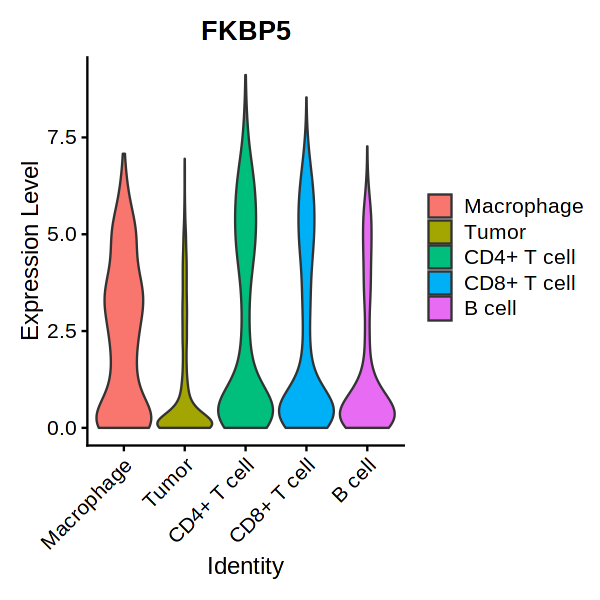

In [7]:
pbmc = res

pbmc@meta.data$cell = NA
pbmc@meta.data$cell[pbmc@meta.data$type == "B"] = "B cell"
pbmc@meta.data$cell[pbmc@meta.data$type == "Macrophage"] = "Macrophage"
pbmc@meta.data$cell[pbmc@meta.data$type == "CD8 T"] = "CD8+ T cell"
pbmc@meta.data$cell[pbmc@meta.data$type == "Naive CD4 T" | pbmc@meta.data$type == "Memory CD4 T" ] = "CD4+ T cell"
pbmc@meta.data$cell[pbmc@meta.data$type == "Tumor"] = "Tumor"

pbmc@meta.data$value = ifelse(is.na(pbmc@meta.data$cell)==FALSE,1,0)

res <- subset(x = pbmc, subset = value == 1)

Idents(object = res) <- res@meta.data$cell
my_levels <- c('Macrophage','Tumor','CD4+ T cell','CD8+ T cell', 'B cell')
Idents(object = res) <- factor(Idents(object=res), levels= my_levels)


library(repr)
library(ggplot2)
options(repr.plot.width=5, repr.plot.height=5)
VlnPlot(res, features = c("FKBP5"), pt.size = 0)
ggsave('/mnt/grid/janowitz/home/skleeman/cystatinc/figure_prep/figure4g_FKBP5.pdf', width=5.5, height=5)

[[1]]


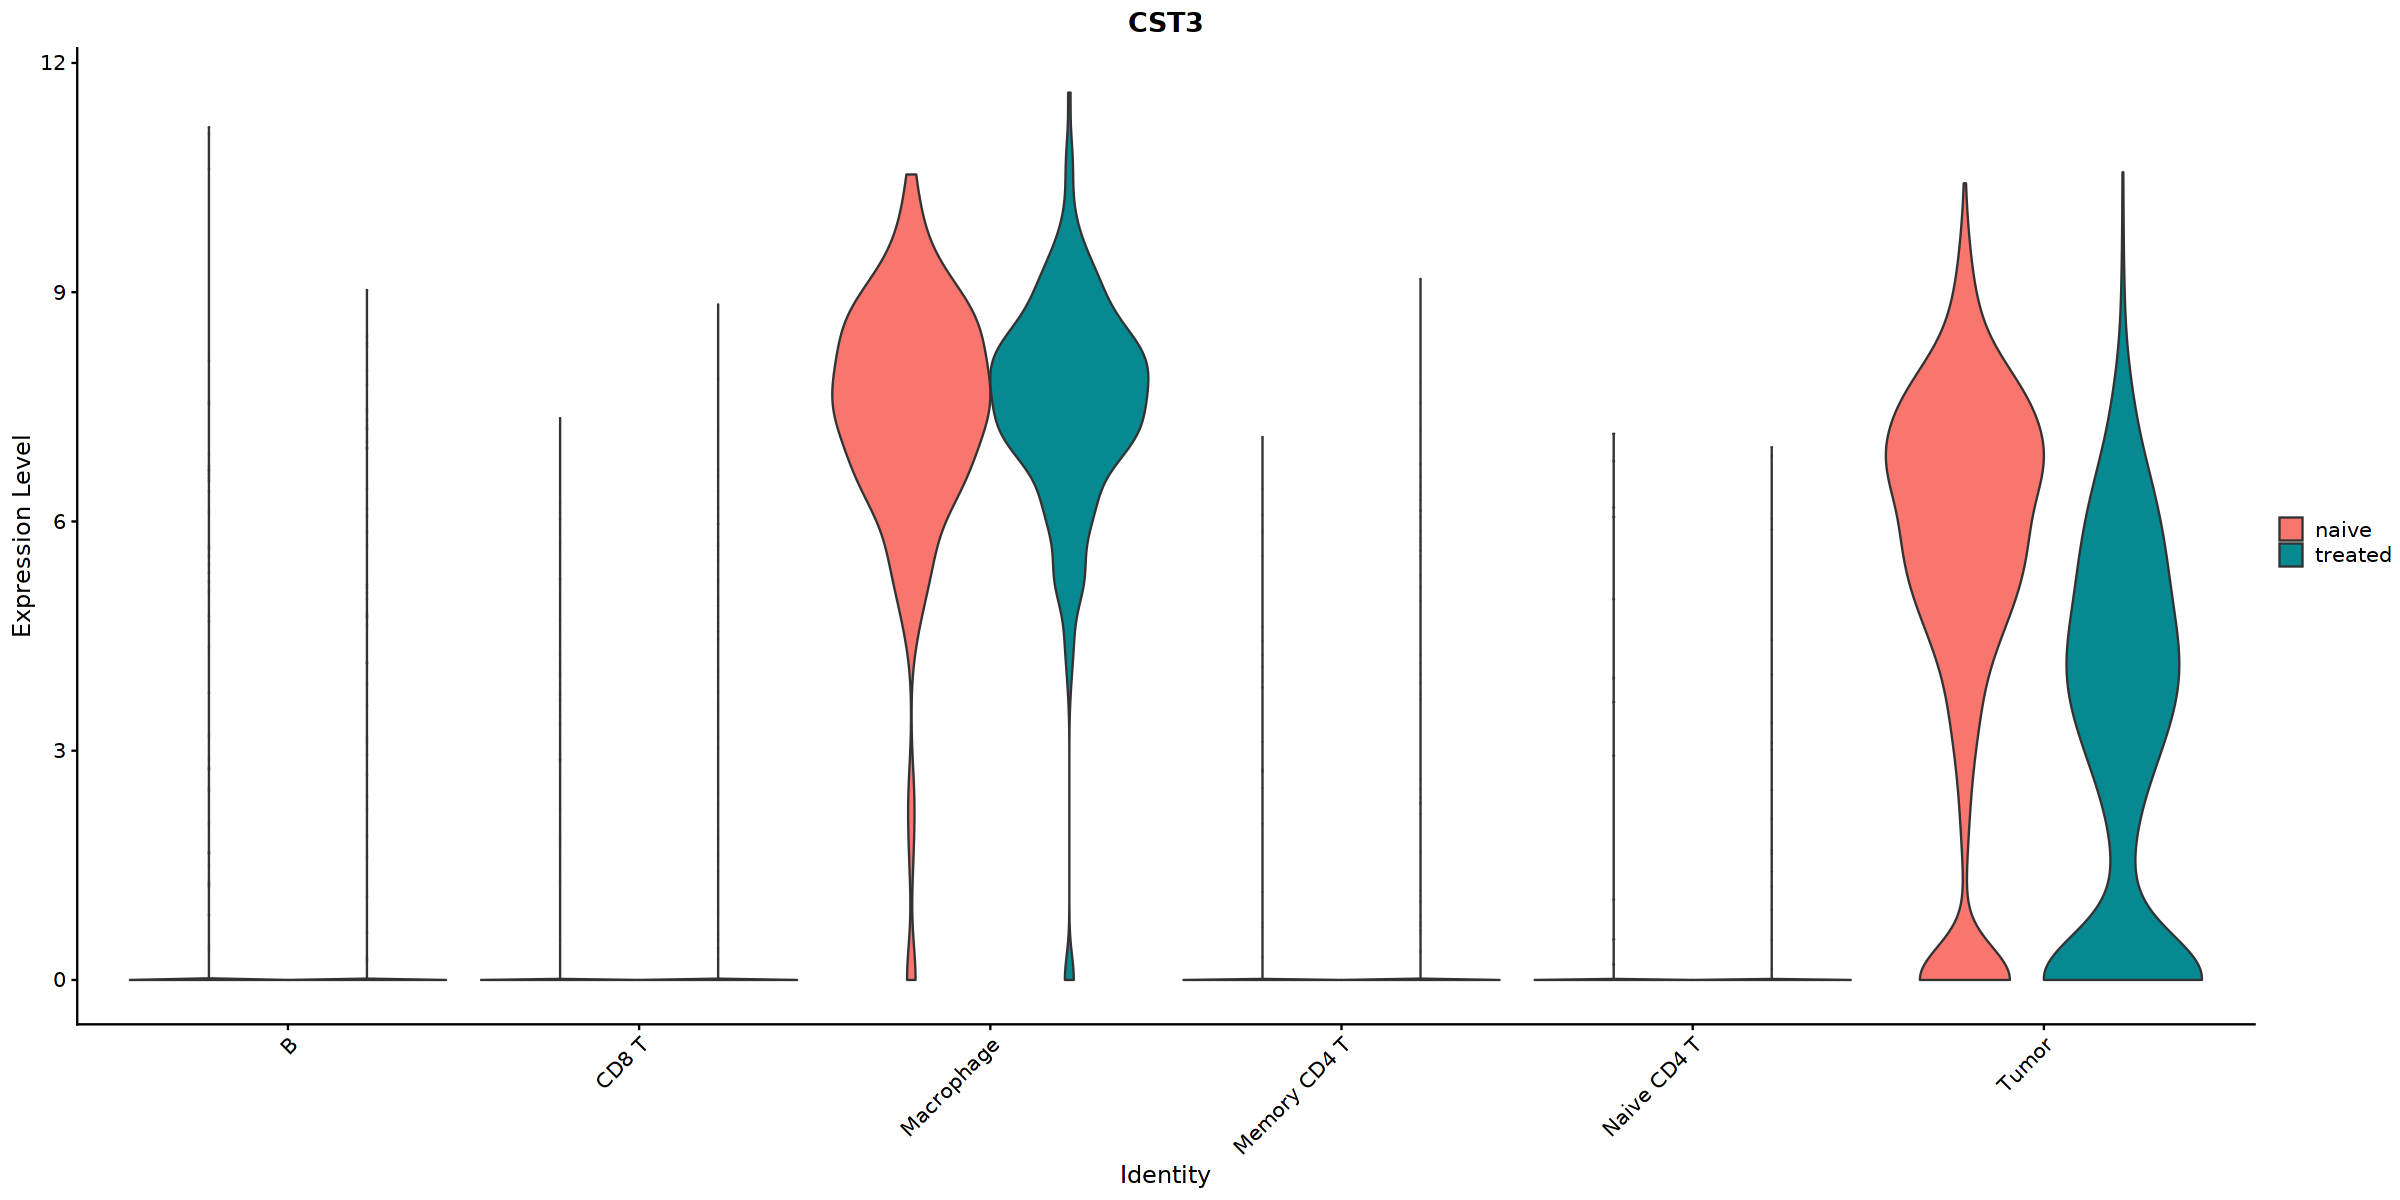

In [71]:
VlnPlot(res, features = c("CST3"), split.by = "response", group.by = "type", 
    pt.size = 0, combine = FALSE)

## BCC (Yost et al)


In [28]:
clinical

patient response tumor_change peritumoral_only
1  su001   Yes       -81         no              
2  su002   Yes         0         no              
3  su003   Yes      -100         no              
4  su004   Yes       -25         no              
5  su005   No          5         no              
6  su006   No        -11         no              
7  su007   No         10         no              
8  su008   No          0         no              
9  su009   Yes       -62         yes             
10 su010-S Yes      -100         no              
11 su010   No         10         yes             
12 su011   Yes      -100         noß             
13 su012   Yes       -57         yes             
14 su013   No          3         yes             
15 su014   No        117         yes

In [ ]:
library(Seurat)
library(data.table)
counts_melanoma = fread('/mnt/grid/janowitz/rdata_norepl/single_cell/bcc/GSE123813_bcc_scRNA_counts.txt.gz')
names = counts_melanoma$V1
counts_melanoma = counts_melanoma[,-1]
row.names(counts_melanoma) = names

metadata = fread('/mnt/grid/janowitz/rdata_norepl/single_cell/bcc/GSE123813_bcc_all_metadata.txt.gz')
names = metadata$cell.id
metadata = metadata[,-1]
row.names(metadata) = names

clinical = read_excel('/mnt/grid/janowitz/rdata_norepl/single_cell/bcc/yost_clinical.xlsx')
#clinical$response = ifelse(clinical$tumor_change < 0, "Yes", "No")
#clinical$response[clinical$tumor_change > -25 & clinical$tumor_change < 25] = "SD"
m<-match(metadata$patient, clinical$patient)
metadata$response = clinical$response[m]
metadata$peritumoral = clinical$peritumoral_only[m]

melanoma <- CreateSeuratObject(counts = data.matrix(counts_melanoma), project = "bcc_yost", min.cells = 10, min.features = 200,
                              meta.data = metadata)

melanoma <- subset(melanoma, subset = peritumoral == "no")

melanoma <- NormalizeData(melanoma, normalization.method = "LogNormalize", scale.factor = 1000000) #CPM

melanoma[["percent.mt"]] <- PercentageFeatureSet(melanoma, pattern = "^MT-")
VlnPlot(melanoma, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
melanoma <- subset(melanoma, subset = nFeature_RNA > 750 & nFeature_RNA < 5000 & percent.mt < 15)


melanoma <- FindVariableFeatures(melanoma, selection.method = "vst", nfeatures = 2000)


all.genes <- rownames(melanoma)
melanoma <- ScaleData(melanoma, features = all.genes)

melanoma <- RunPCA(object = melanoma, npcs=30)
melanoma <- FindNeighbors(object = melanoma, dims = 1:20)
melanoma <- FindClusters(object = melanoma, resolution = 0.5, algorithm = 1)
melanoma <- RunTSNE(object = melanoma, dims.use = 1:10)
DimPlot(object = melanoma, reduction = "tsne")
melanoma <- RunUMAP(melanoma, reduction = "pca", dims = 1:20)
DimPlot(melanoma, reduction = "umap")



13:51:04 UMAP embedding parameters a = 0.9922 b = 1.112

13:51:04 Read 38949 rows and found 20 numeric columns

13:51:04 Using Annoy for neighbor search, n_neighbors = 30

13:51:04 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:51:08 Writing NN index file to temp file /tmp/3843246.1.comp.q/Rtmp6dXRr0/file1565ea790b9629

13:51:08 Searching Annoy index using 1 thread, search_k = 3000

13:51:21 Annoy recall = 100%

13:51:22 Commencing smooth kNN distance calibration using 1 thread

13:51:25 Initializing from normalized Laplacian + noise

13:51:38 Commencing optimization for 200 epochs, with 1687528 positive edges

13:51:56 Optimization finished



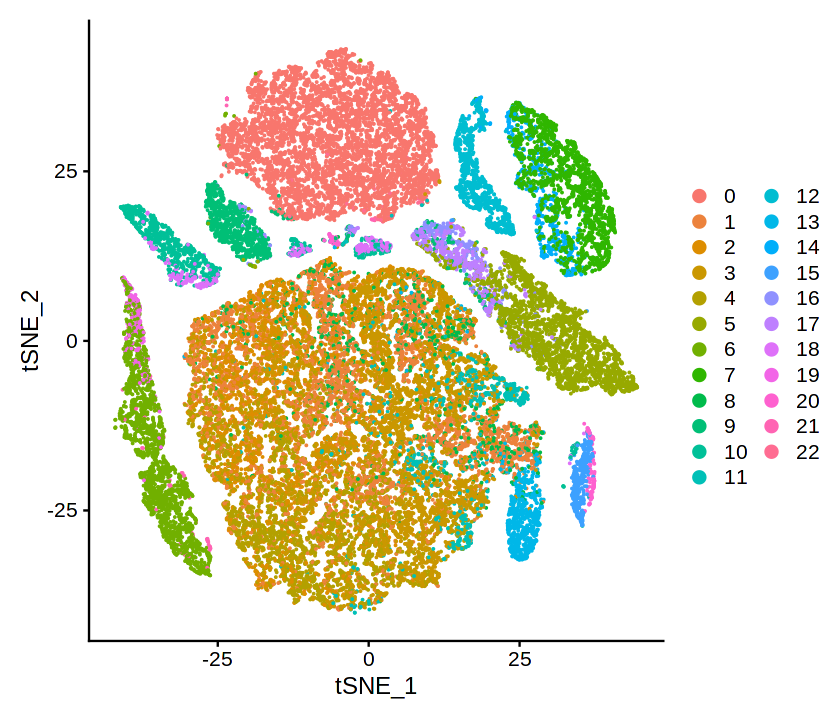

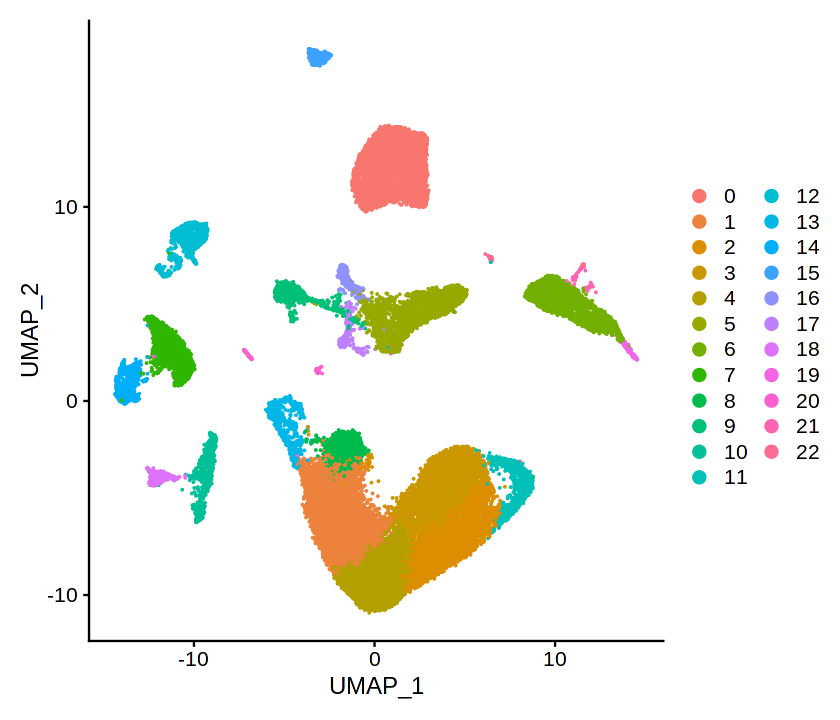

In [47]:
DimPlot(object = melanoma, reduction = "tsne")
melanoma <- RunUMAP(melanoma, reduction = "pca", dims = 1:20)
DimPlot(melanoma, reduction = "umap")


using threshold of 0.52



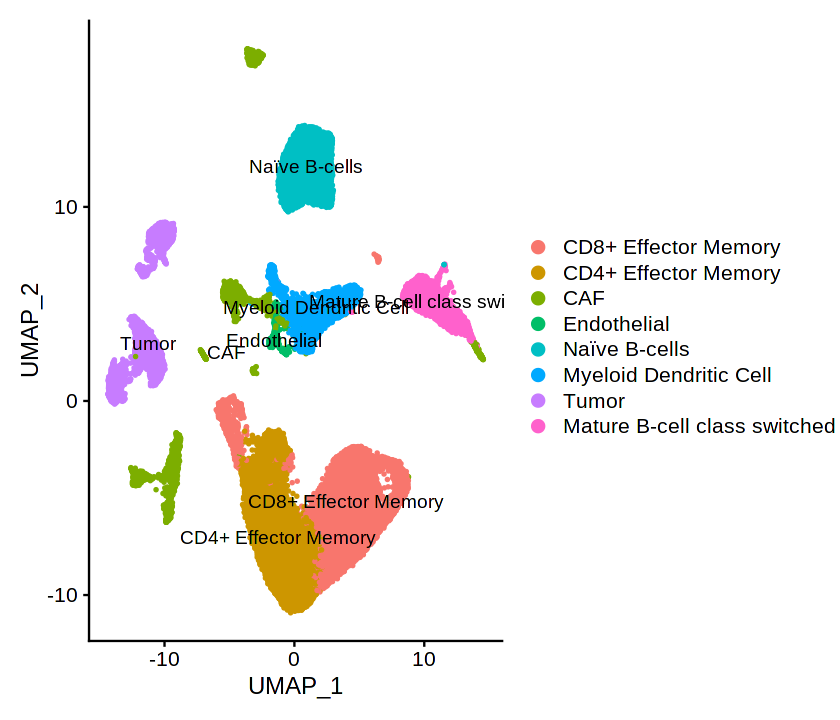

In [63]:
options(repr.plot.width=7, repr.plot.height=6)

library(clustifyr)
library(clustifyrdata)

res <- clustify(
  input = melanoma,       # a Seurat object
  ref_mat = clustifyrdata::ref_hema_microarray,    # matrix of RNA-seq expression data for each cell type
  cluster_col = "RNA_snn_res.0.5", # name of column in meta.data containing cell clusters
  obj_out = TRUE,      # output Seurat object with cell type inserted as "type" column
  query_genes = clustifyrdata::pbmc_vargenes[1:500]
)

res@meta.data$type[res@meta.data$seurat_clusters==9]='CAF'
res@meta.data$type[res@meta.data$seurat_clusters==14]='Endothelial'
res@meta.data$type[res@meta.data$seurat_clusters==17]='Endothelial'

res@meta.data$type[res@meta.data$type=='CD14+ Mono']='Macrophage'
res@meta.data$type[res@meta.data$type=='unassigned']='CAF'

res@meta.data$type[grepl('Tumor',res@meta.data$cluster)==TRUE]='Tumor'

Idents(object = res) <- res@meta.data$type

DimPlot(res, reduction = "umap", label = TRUE, pt.size = 0.5)

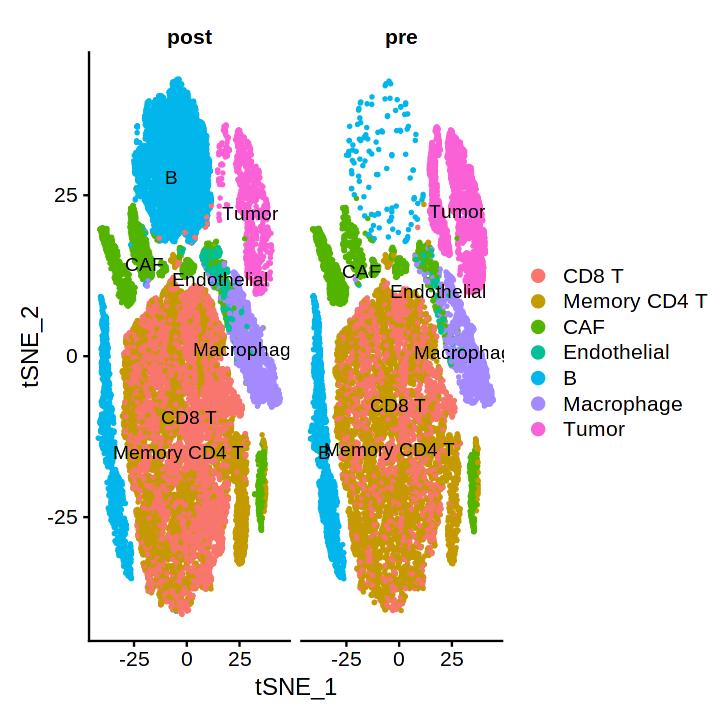

In [61]:
DimPlot(res, reduction = "tsne", label = TRUE, pt.size = 0.5, split.by = "treatment")

In [53]:
#Loop
framex = data.frame()
for(responsex in c("Yes","No")) {
    print(responsex)
    interest <- subset(x = res, subset = response == responsex)
    interest <- subset(x = interest, subset = patient != "su001")
    interest <- subset(x = interest, subset = patient != "su002")

    for(celltypex in c("Macrophage","DC","CAF","Tumor")) {
        #Idents(object = interest) <- interest@meta.data$treatment
        #interest2 <- subset(x = interest, subset = type == celltypex)

        #markers <- FindMarkers(interest2, ident.1 = "post", ident.2 = "pre", verbose = FALSE,min.pct = 0.0, features="CST3",logfc.threshold
        #=0)
        markers = FindMarkers(interest, test.use="LR", latent.vars = 'patient', group.by = 'treatment', subset.ident = celltypex, logfc.threshold=0,verbose = FALSE,min.pct = 0.0, features="CST3",
                             ident.1 = "post", ident.2 = "pre")
        #markers = FindMarkers(interest2, test.use="LR", latent.vars = 'patient', ident.1 = "post", ident.2 = "pre", logfc.threshold=0,verbose = FALSE,min.pct = 0.0, features="CST3")
        add = data.frame(response=responsex, celltype=celltypex)
        markers = cbind(add, markers)
        framex = rbind(framex, markers)
    }
}

[1] "Yes"
[1] "No"


In [54]:
framex

response celltype   p_val        avg_log2FC pct.1 pct.2 p_val_adj   
CST3  Yes      Macrophage 4.783753e-05 -1.5192732 0.983 1.000 9.943988e-01
CST31 Yes      DC         6.703145e-02 -1.6098638 0.898 1.000 1.000000e+00
CST32 Yes      CAF        9.317680e-02 -1.3061511 0.988 1.000 1.000000e+00
CST33 Yes      Tumor      5.043913e-01 -0.8088690 0.422 0.500 1.000000e+00
CST34 No       Macrophage 2.847222e-44  1.0906485 0.992 0.935 5.918520e-40
CST35 No       DC         9.885600e-31  0.8143586 0.964 0.857 2.054920e-26
CST36 No       CAF        6.611021e-21  0.3848295 0.983 0.915 1.374233e-16
CST37 No       Tumor      8.369558e-14 -0.6637198 0.521 0.447 1.739780e-09

Warning message:
“Removed 2 rows containing missing values (geom_text_repel).”


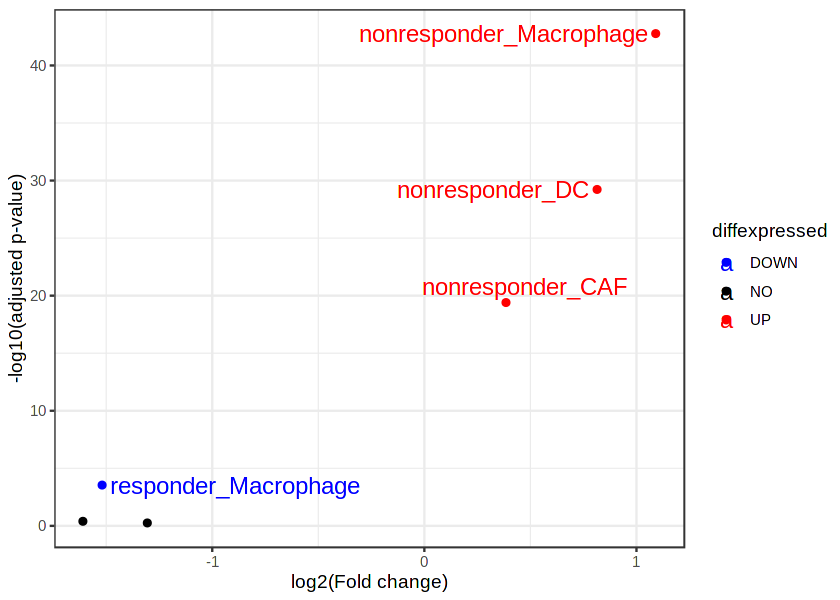

In [51]:
framex$fdr = p.adjust(framex$p_val, method='bonf')

library(ggplot2)
options(repr.plot.width=7, repr.plot.height=5)


de = framex

# add a column of NAs
de$diffexpressed <- "NO"
# if log2Foldchange > 0.6 and pvalue < 0.05, set as "UP" 
de$diffexpressed[de$avg_log2FC > 0.2 & de$fdr < 0.01] <- "UP"
# if log2Foldchange < -0.6 and pvalue < 0.05, set as "DOWN"
de$diffexpressed[de$avg_log2FC < 0.2 & de$fdr < 0.01] <- "DOWN"

de$delabel <- NA
de$delabel[de$diffexpressed != "NO"] <- paste(ifelse(de$response[de$diffexpressed != "NO"]=="Yes","responder","nonresponder"),de$celltype[de$diffexpressed != "NO"], sep='_')


library(ggrepel)
# plot adding up all layers we have seen so far
ggplot(data=de, aes(x=avg_log2FC, y=-log10(fdr), col=diffexpressed, label=delabel)) +
        geom_point() + 
        theme_bw() +
        geom_text_repel(size=5) +
        scale_color_manual(values=c("blue", "black", "red"))+xlab("log2(Fold change)") +ylab("-log10(adjusted p-value)")

In [47]:
out = AverageExpression(
  subset(x = res, subset = type == "Tumor"),slot="data",
  group.by = c('response',"treatment", "patient"),features=c("CST3"),assay="RNA"
)
out = as.data.frame(t(out$RNA))
library(stringr)
x <- strsplit(row.names(out), "_")
out$response = sapply( x, "[", 1)
out$treatment = sapply( x, "[", 2)
out$patient = sapply( x, "[", 3)

out$treatment <- factor(out$treatment, levels = c("pre", "post"))

out = out %>% 
    group_by(patient) %>% 
    mutate(val_norm = 2^V1/2^V1[treatment=="pre"][1L])

out %>% 
  group_by(patient) %>% 
  filter(n_distinct(V1) < 2)


V1        response treatment patient val_norm
1 0.1649615 Yes      pre       su001   1       
2 0.9206625 Yes      pre       su002   1


	Paired t-test

data:  test1$post and test1$pre
t = -0.80586, df = 2, p-value = 0.5049
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.7775308  0.5322230
sample estimates:
mean of the differences 
             -0.1226539 


	Paired t-test

data:  test2$post and test2$pre
t = 3.0281, df = 4, p-value = 0.03885
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.04104863 0.94672415
sample estimates:
mean of the differences 
              0.4938864 



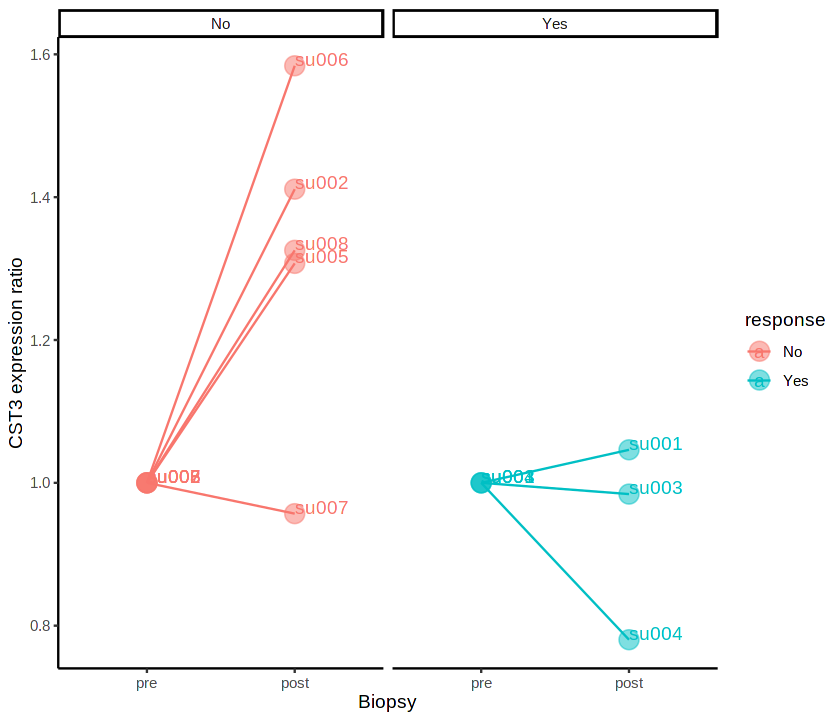

In [48]:
out = AverageExpression(
  subset(x = res, subset = type == "DC"),slot="scale.data",
  group.by = c('response',"treatment", "patient"),features=c("CST3"),assay="RNA"
)
out = as.data.frame(t(out$RNA))
library(stringr)
x <- strsplit(row.names(out), "_")
out$response = sapply( x, "[", 1)
out$treatment = sapply( x, "[", 2)
out$patient = sapply( x, "[", 3)

out$treatment <- factor(out$treatment, levels = c("pre", "post"))

out = out %>% 
    group_by(patient) %>% 
    mutate(val_norm = V1/V1[treatment=="pre"][1L])

out = out %>% 
  group_by(patient) %>% 
  filter(n_distinct(V1) >= 2)


out$response[out$patient=="su008" | out$patient=="su002"]="No"

test = out %>% dplyr::select(-val_norm) %>%
  spread(treatment, V1)

test1 = subset(test, response=="Yes")
test2 = subset(test, response=="No")


print(t.test(test1$post, test1$pre,paired=TRUE, ar.equal = FALSE))

print(t.test(test2$post, test2$pre, paired=TRUE))


library(ggplot2)
ggplot(subset(out), aes(y = val_norm, x = treatment, color=response, label=patient)) +  
  geom_point(size = 5, alpha = 0.5) + 
  geom_line(aes(group = patient)) +
  labs(x = "Biopsy", y = "CST3 expression ratio") + 
  theme(text = element_text(size = 18), 
        axis.text = element_text(size = 16), aspect.ratio = 0.80) +
  theme_classic()+facet_wrap(~ response)+geom_text(aes(label=patient),hjust=0, vjust=0)

#ggsave('/mnt/grid/janowitz/home/skleeman/cystatinc/figure_prep/figures5_Tumor.pdf', width=5, height=4)

In [46]:
out

V1       response treatment patient val_norm 
1  1.759141 No       post      su005   1.1450130
2  1.791951 No       post      su006   1.3451998
3  2.080423 No       post      su008   1.1098738
4  1.536350 No       pre       su005   1.0000000
5  1.332108 No       pre       su006   1.0000000
6  1.874468 No       pre       su008   1.0000000
7  1.857586 Yes      post      su001   1.1004823
8  2.262761 No       post      su002   1.2346923
9  2.179566 Yes      post      su003   0.9964399
10 1.796823 Yes      post      su004   0.9163115
11 1.687975 Yes      pre       su001   1.0000000
12 1.832652 No       pre       su002   1.0000000
13 2.187353 Yes      pre       su003   1.0000000
14 1.960930 Yes      pre       su004   1.0000000

In [40]:
look = subset(out, treatment=="pre")
t.test(V1 ~ response, data = look)


	Welch Two Sample t-test

data:  V1 by response
t = -0.69844, df = 2.6989, p-value = 0.5403
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -16047.12  10568.47
sample estimates:
 mean in group No mean in group Yes 
         3629.912          6369.233 


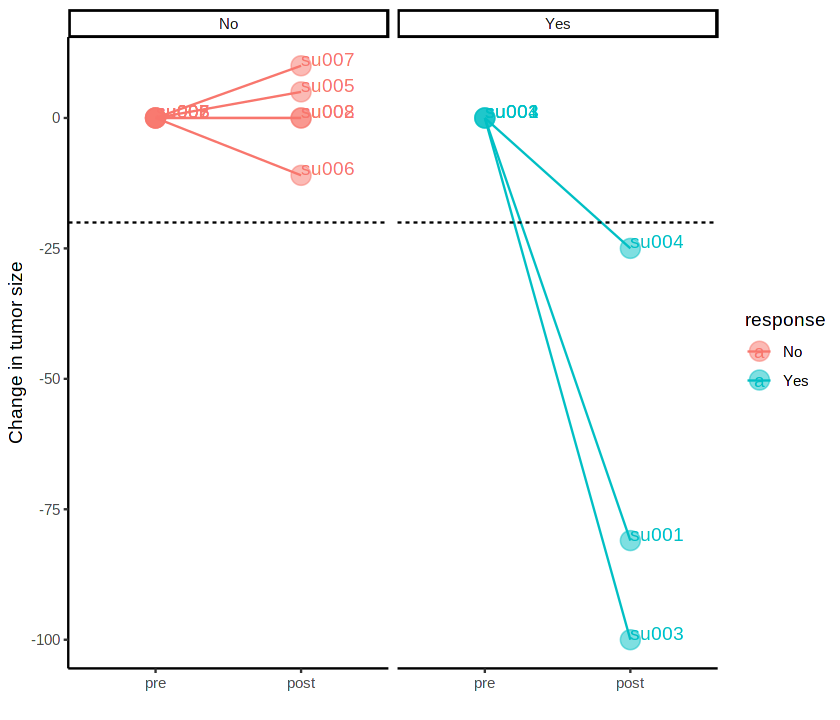

In [47]:
clinicalx = subset(clinical, patient %in% c('su001','su004','su003','su006','su005','su008','su007', 'su002'))
clinicalx$response[clinicalx$patient=="su008" | clinicalx$patient=="su002"]="No"

clinicalx$stage='pre'
clinicaly=clinicalx
clinicaly$stage='post'
clinicalx$tumor_change=0
clinicalx=rbind(clinicalx,clinicaly)

clinicalx$stage <- factor(clinicalx$stage, levels = c("pre", "post"))



library(ggplot2)
ggplot(subset(clinicalx), aes(y = tumor_change, x = stage, color=response, label=patient)) +  
  geom_point(size = 5, alpha = 0.5) + 
  geom_line(aes(group = patient)) +
  labs(x = "", y = "Change in tumor size") + 
  theme(text = element_text(size = 18), 
        axis.text = element_text(size = 16), aspect.ratio = 0.80) +
  theme_classic()+facet_wrap(~ response)+geom_hline(yintercept=-20, linetype="dashed", color = "black")+geom_text(aes(label=patient),hjust=0, vjust=0)


#ggsave('/mnt/grid/janowitz/home/skleeman/cystatinc/figure_prep/figures5_Tumorsize.pdf', width=5, height=4)

## Spleen

In [1]:
pbmc <- readRDS(file = "/mnt/grid/janowitz/rdata_norepl/single_cell/spleen/spleen_ts.rds")


Centering and scaling data matrix

PC_ 1 
Positive:  LTB, MS4A1, TCL1A, IL7R, IL32, CD3D, KLRB1, IGHD, TRAC, CD79A 
	   CCL5, VPREB3, CD7, KLRD1, FCER2, CCR7, TRBC1, TRBC2, STAG3, RP11-164H13.1 
	   GZMK, PCDH9, CD22, CD69, GZMA, CD8B, SLC38A11, LEF1, TRAT1, RPS4Y1 
Negative:  SERPINA1, CST3, LYZ, FCN1, AIF1, CSTA, CPVL, CD14, MS4A6A, FPR1 
	   FGL2, IGSF6, MNDA, CD68, CFP, CFD, VCAN, NCF2, RP11-1143G9.4, HCK 
	   LGALS2, CLEC7A, FCGR2A, TNFSF13B, PLBD1, KCTD12, LST1, CD36, LILRB2, CLEC4E 
PC_ 2 
Positive:  FCN1, SERPINA1, VCAN, CD14, CSTA, FPR1, RP11-1143G9.4, MNDA, LYZ, S100A12 
	   CFD, CST3, MS4A6A, CLEC4E, AIF1, CFP, LILRA5, CD36, PLBD1, CD300E 
	   CPVL, LINC01272, IGSF6, FCGR2A, S100A9, FCGR1A, NCF2, TNFSF13B, LILRB2, TMEM176B 
Negative:  BIRC5, MKI67, RRM2, KIAA0101, UBE2C, TYMS, TK1, CDKN3, AURKB, ZWINT 
	   CDC20, NUSAP1, TOP2A, GTSE1, CDK1, CENPA, CCNB2, ASPM, TPX2, SPC25 
	   MYBL2, CCNA2, HMMR, PTTG1, SHCBP1, PLK1, CENPW, GGH, CDCA3, CENPF 
PC_ 3 
Positive:  HLA-DRA, CD79A

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 94257
Number of edges: 2786908

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9201
Number of communities: 16
Elapsed time: 65 seconds


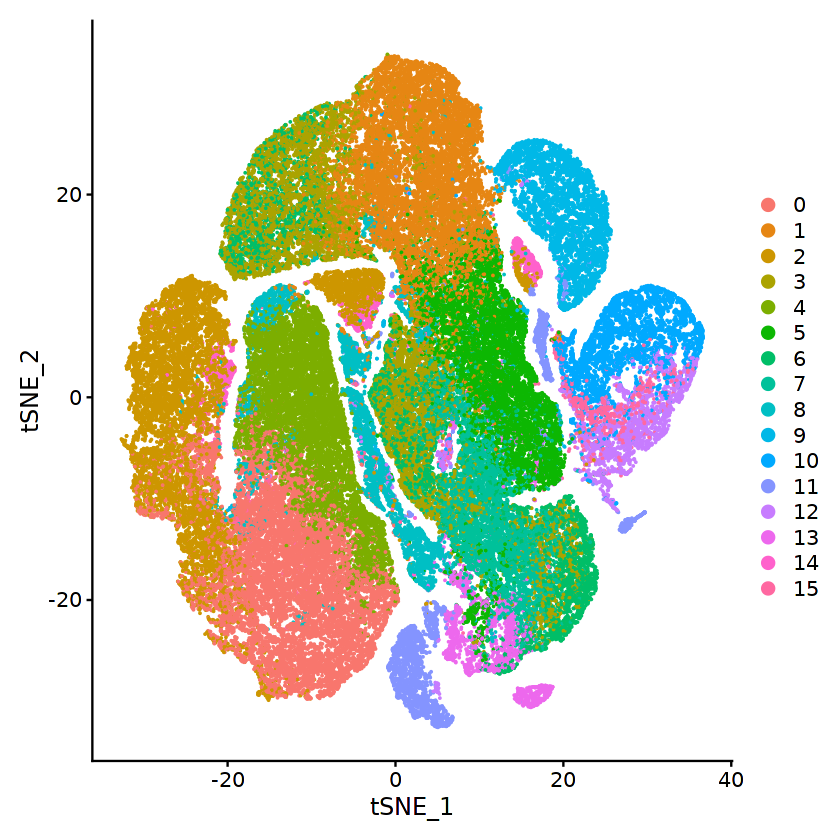

In [4]:
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 1000000) #CPM

pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)

all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)
pbmc <- RunPCA(object = pbmc, features = VariableFeatures(object = pbmc))
pbmc <- FindNeighbors(object = pbmc, dims = 1:10)
pbmc <- FindClusters(object = pbmc, resolution = 0.5)
pbmc <- RunTSNE(object = pbmc, dims.use = 1:10)
DimPlot(object = pbmc, reduction = "tsne")

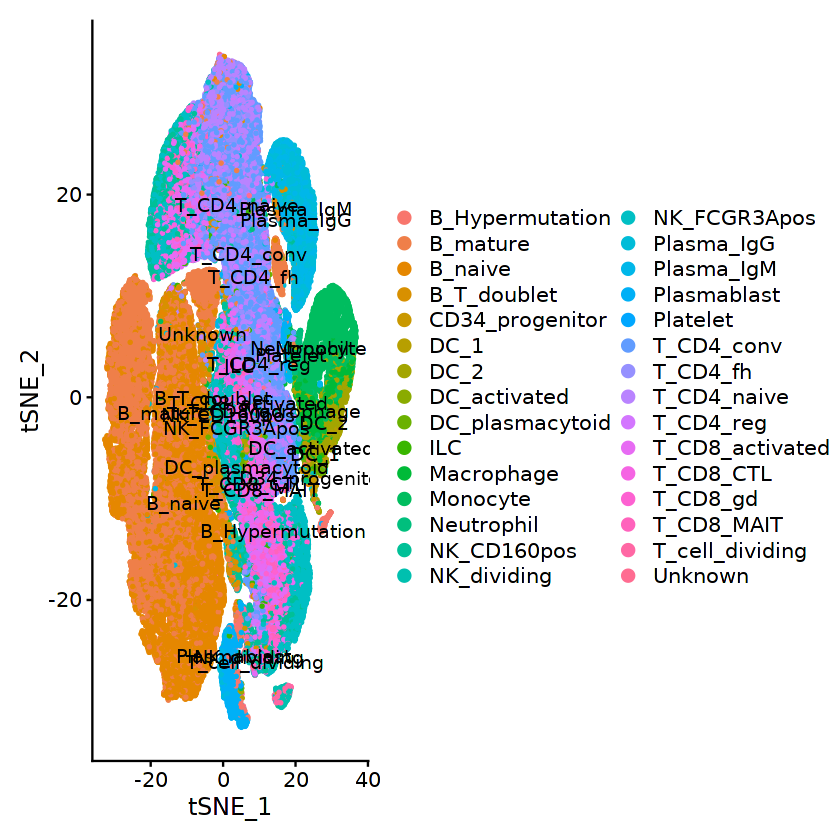

In [6]:
Idents(object = pbmc) <- pbmc@meta.data$Celltypes_updated_July_2020

DimPlot(pbmc, reduction = "tsne", label = TRUE, pt.size = 0.5)

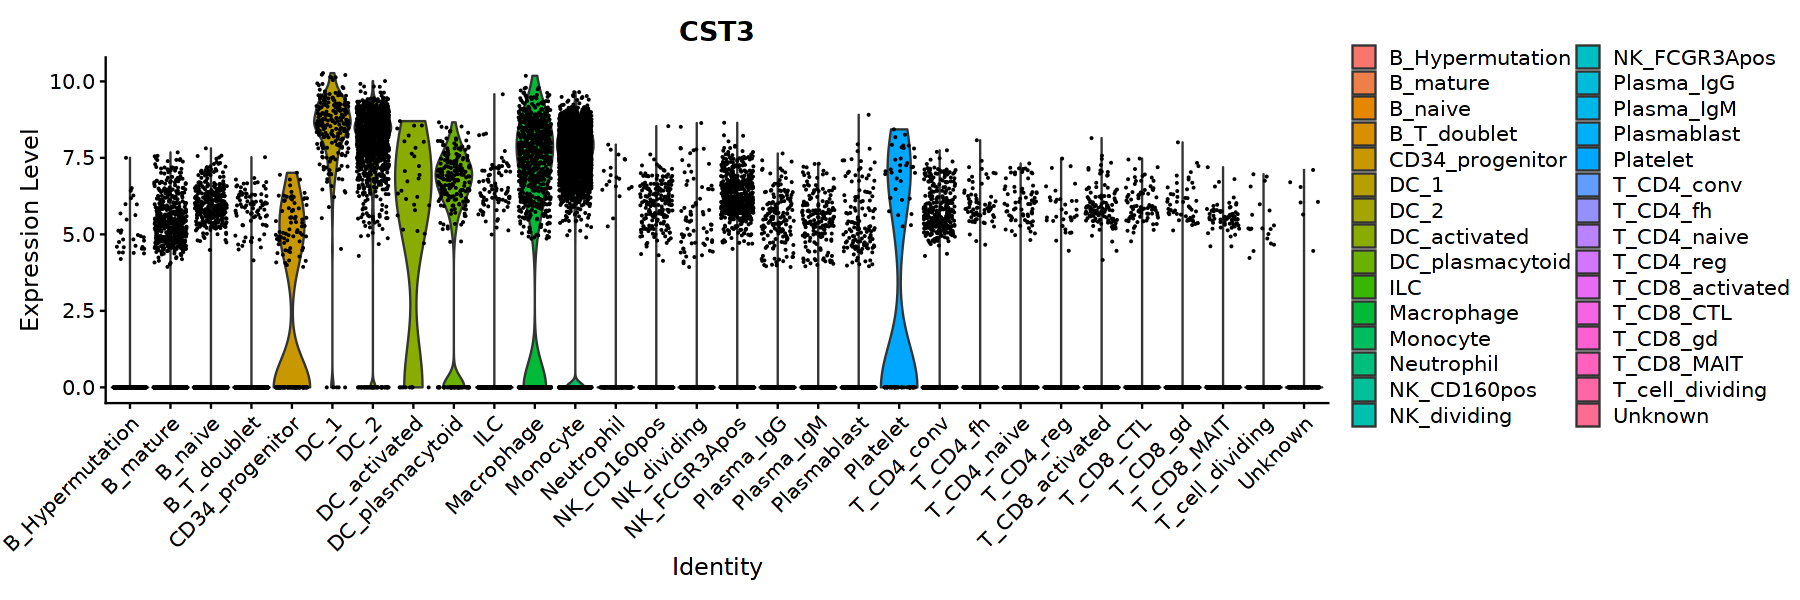

In [9]:
library(ggplot2)
options(repr.plot.width=15, repr.plot.height=5)
VlnPlot(pbmc, features = c("CST3"))

In [23]:
pbmc@meta.data$cell = NA
pbmc@meta.data$cell[pbmc@meta.data$Celltypes_updated_July_2020 == "Neutrophil"] = "Neutrophil"
pbmc@meta.data$cell[pbmc@meta.data$Celltypes_updated_July_2020 == "Macrophage"] = "Macrophage"
pbmc@meta.data$cell[pbmc@meta.data$Celltypes_updated_July_2020 == "Monocyte"] = "Monocyte"

pbmc@meta.data$cell[pbmc@meta.data$Celltypes_updated_July_2020 %in% c('B_Hypermutation','B_mature','B_naive')] = 'B cell'
pbmc@meta.data$cell[pbmc@meta.data$Celltypes_updated_July_2020 %in% c('Plasma_IgG','Plasma_IgM','Plasmablast')] = 'Plasma cell'
pbmc@meta.data$cell[pbmc@meta.data$Celltypes_updated_July_2020 %in% c('DC_1','DC_2','DC_activated','DC_plasmacytoid')] = 'Dendritic cell'
pbmc@meta.data$cell[pbmc@meta.data$Celltypes_updated_July_2020 %in% c('NK_CD160pos','NK_dividing','NK_FCGR3Apos')] = 'NK cell'
pbmc@meta.data$cell[grepl('T_',pbmc@meta.data$Celltypes_updated_July_2020)==TRUE]='T cell'

pbmc@meta.data$value = ifelse(is.na(pbmc@meta.data$cell)==FALSE,1,0)

In [33]:
res <- subset(x = pbmc, subset = value == 1)


Idents(object = res) <- res@meta.data$cell
my_levels <- c('Dendritic cell','Macrophage','Monocyte','T cell','B cell','Plasma cell','NK cell','Neutrophil')
Idents(object = res) <- factor(Idents(object=res), levels= my_levels)



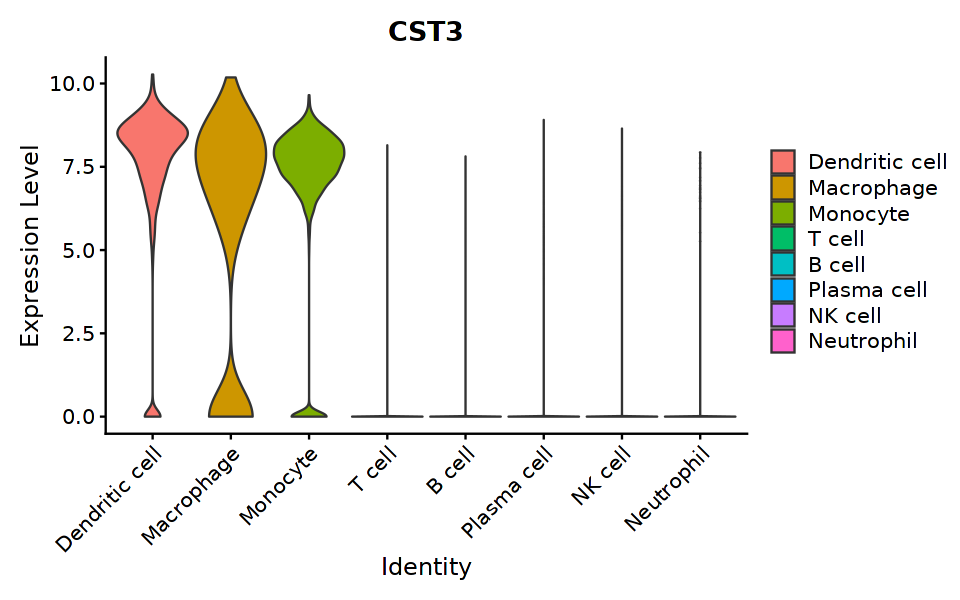

In [36]:

library(repr)
options(repr.plot.width=8, repr.plot.height=5)
VlnPlot(res, features = c("CST3"), pt.size = 0)
ggsave('/mnt/grid/janowitz/home/skleeman/cystatinc/figure_prep/figure3b.pdf', width=8, height=5)

In [35]:
table(res@meta.data$cell)


        B cell Dendritic cell     Macrophage       Monocyte     Neutrophil 
         35236           1956           1035           3717            161 
       NK cell    Plasma cell         T cell 
         14458           6040          30717 

## PBMCs (ICA)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Centering and scaling data matrix

PC_ 1 
Positive:  CST3, CSTA, LYZ, FCN1, S100A9, LST1, TYMP, MNDA, S100A8, SERPINA1 
	   CFD, TYROBP, FCER1G, SPI1, FTL, S100A12, CLEC12A, VCAN, CD68, LGALS1 
	   RP11-1143G9.4, MS4A6A, FGL2, CTSS, AIF1, NCF2, IFI30, CFP, TNFSF13B, HLA-DRA 
Negative:  IL32, TRAC, RPSA, CD3D, CD3E, RPL5, LTB, LDHB, TRBC2, LCK 
	   RPL10A, CD52, RPS5, RPL4, CD7, IL7R, NPM1, AES, GLTSCR2, EVL 
	   RPLP0, BTG1, HLA-A, CD27, HSPA8, EEF1B2, CD3G, HLA-C, ACAP1, RPS10 
PC_ 2 
Positive:  NKG7, CST7, GZMA, PRF1, CCL5, GZMB, KLRD1, CTSW, FGFBP2, GNLY 
	   GZMH, KLRF1, TRDC, HOPX, HCST, CCL4, SPON2, SRGN, KLRB1, FCGR3A 
	   S100A4, CLIC3, MATK, MYOM2, ID2, MYO1F, GZMM, CD247, S1PR5, ANXA1 
Negative:  CD79A, MS4A1, IGHD, TCL1A, IGHM, HLA-DQA1, LTB, FCER2, CD79B, LINC00926 
	   HLA-DRA, BANK1, VPREB3, HLA-DQB1, HLA-DMA, CD22, TNFRSF13C, FCRLA, HLA-DOB, TSPAN13 
	   NCF1, MEF2C, HVCN1, HLA-DR

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 13427
Number of edges: 444098

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9280
Number of communities: 11
Elapsed time: 1 seconds


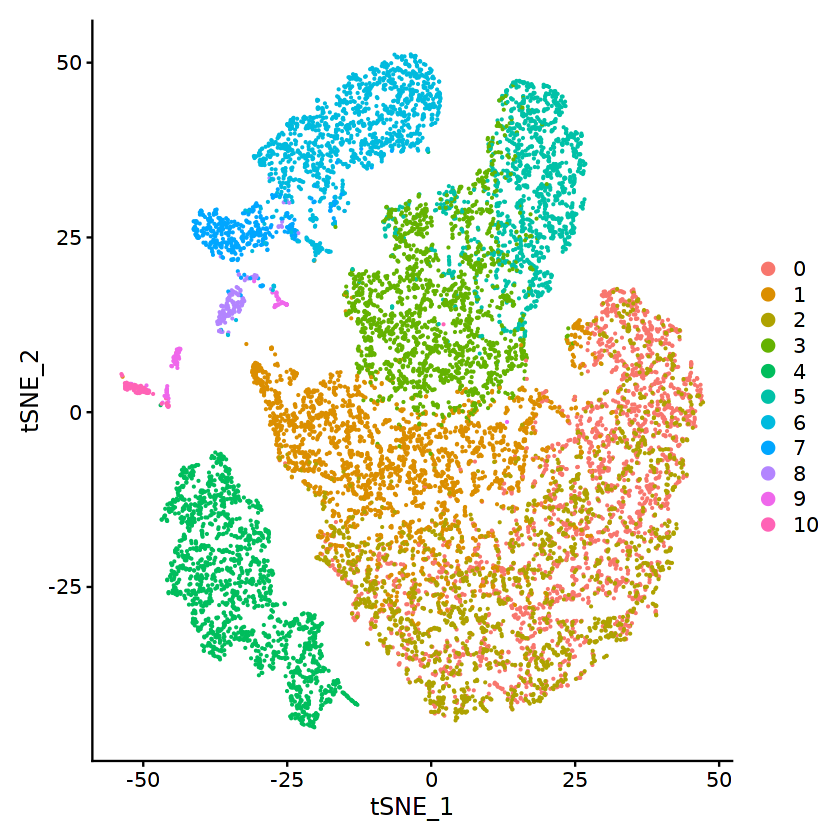

In [6]:
library(Seurat)
library(data.table)
counts_melanoma = fread('/mnt/grid/janowitz/rdata_norepl/single_cell/pbmc/SCP345/expression/pbmc_site_bc.scp.expr.txt')
names = counts_melanoma$GENE
counts_melanoma = counts_melanoma[,-1]
row.names(counts_melanoma) = names

metadata = fread('/mnt/grid/janowitz/rdata_norepl/single_cell/pbmc/SCP345/metadata/pbmc_cca_final_metadata_lineage1lineage2.txt')
metadata = metadata[-1,]
names = metadata$NAME
metadata = metadata[,-1]
row.names(metadata) = names

melanoma <- CreateSeuratObject(counts = data.matrix(counts_melanoma), project = "melanoma_scp398", min.cells = 10, min.features = 200)


melanoma <- FindVariableFeatures(melanoma, selection.method = "vst", nfeatures = 2000)

all.genes <- rownames(melanoma)
melanoma <- ScaleData(melanoma, features = all.genes)

melanoma <- RunPCA(object = melanoma, features = VariableFeatures(object = melanoma))
melanoma <- FindNeighbors(object = melanoma, dims = 1:10)
melanoma <- FindClusters(object = melanoma, resolution = 0.3)
melanoma <- RunTSNE(object = melanoma, dims.use = 1:10)
DimPlot(object = melanoma, reduction = "tsne")


cannot find dr info

using threshold of 0.7



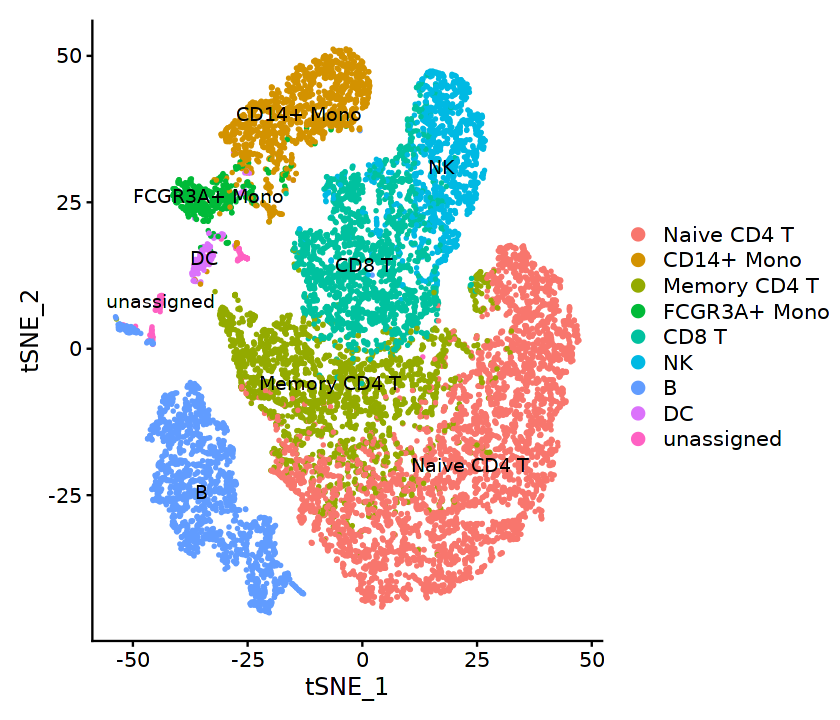

In [12]:
options(repr.plot.width=7, repr.plot.height=6)

library(clustifyr)
library(clustifyrdata)

res <- clustify(
  input = melanoma,       # a Seurat object
  ref_mat = clustifyrdata::pbmc_avg,    # matrix of RNA-seq expression data for each cell type
  cluster_col = "RNA_snn_res.0.3", # name of column in meta.data containing cell clusters
  obj_out = TRUE,      # output Seurat object with cell type inserted as "type" column
  query_genes = clustifyrdata::pbmc_vargenes[1:500]
)


Idents(object = res) <- res@meta.data$type

DimPlot(res, reduction = "tsne", label = TRUE, pt.size = 0.5)

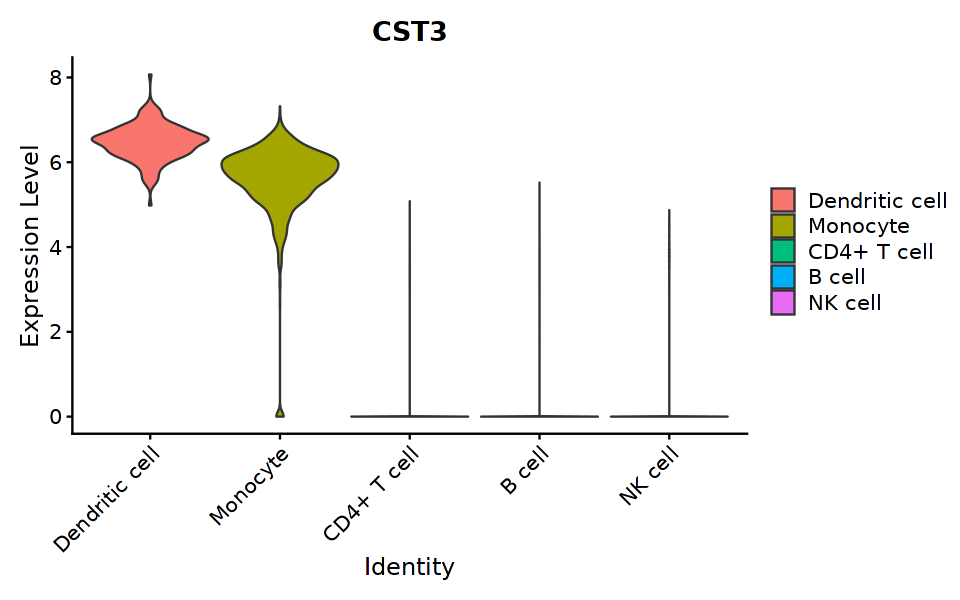

In [16]:
pbmc = res

pbmc@meta.data$cell = NA
pbmc@meta.data$cell[pbmc@meta.data$type == "NK"] = "NK cell"
pbmc@meta.data$cell[pbmc@meta.data$type == "B"] = "B cell"
pbmc@meta.data$cell[pbmc@meta.data$type == "DC"] = "Dendritic cell"
pbmc@meta.data$cell[pbmc@meta.data$type == "CD8"] = "CD8+ T cell"
pbmc@meta.data$cell[pbmc@meta.data$type == "Naive CD4 T" | pbmc@meta.data$type == "Memory CD4 T" ] = "CD4+ T cell"
pbmc@meta.data$cell[pbmc@meta.data$type == "CD14+ Mono" | pbmc@meta.data$type == "FCGR3A+ Mono" ] = "Monocyte"

pbmc@meta.data$value = ifelse(is.na(pbmc@meta.data$cell)==FALSE,1,0)

res <- subset(x = pbmc, subset = value == 1)


Idents(object = res) <- res@meta.data$cell
my_levels <- c('Dendritic cell','Monocyte','CD8+ T cell','CD4+ T cell', 'B cell','NK cell')
Idents(object = res) <- factor(Idents(object=res), levels= my_levels)


library(repr)
options(repr.plot.width=8, repr.plot.height=5)
VlnPlot(res, features = c("CST3"), pt.size = 0)
ggsave('/mnt/grid/janowitz/home/skleeman/cystatinc/figure_prep/figure3c.pdf', width=7, height=5)